# Plot Customisation with `doped`

All the plotting functions in `doped` are made to be as customisable as possible, and also return the `Matplotlib` `Figure` object, so that you can further customise the plot as you see fit. 

```{tip}
You can run this notebook interactively through [Google Colab](https://colab.research.google.com/github/SMTG-Bham/doped/blob/develop/examples/plotting_customisation_tutorial.ipynb) or [Binder](https://mybinder.org/v2/gh/SMTG-Bham/doped/develop?urlpath=tree/examples/plotting_customisation_tutorial.ipynb) – just click the links!
If running on Colab, then you'll need to run `!pip install doped` in a cell to install the package, and `!git clone https://github.com/SMTG-Bham/doped` to download the example data (and update paths in the code cells accordingly).
```

## Defect Formation Energy Plotting

In [1]:
%matplotlib inline
from monty.serialization import loadfn
CdTe_thermo = loadfn("CdTe/CdTe_thermo_wout_meta.json.gz")  # load our DefectThermodynamics object

Basic formation energy plot:

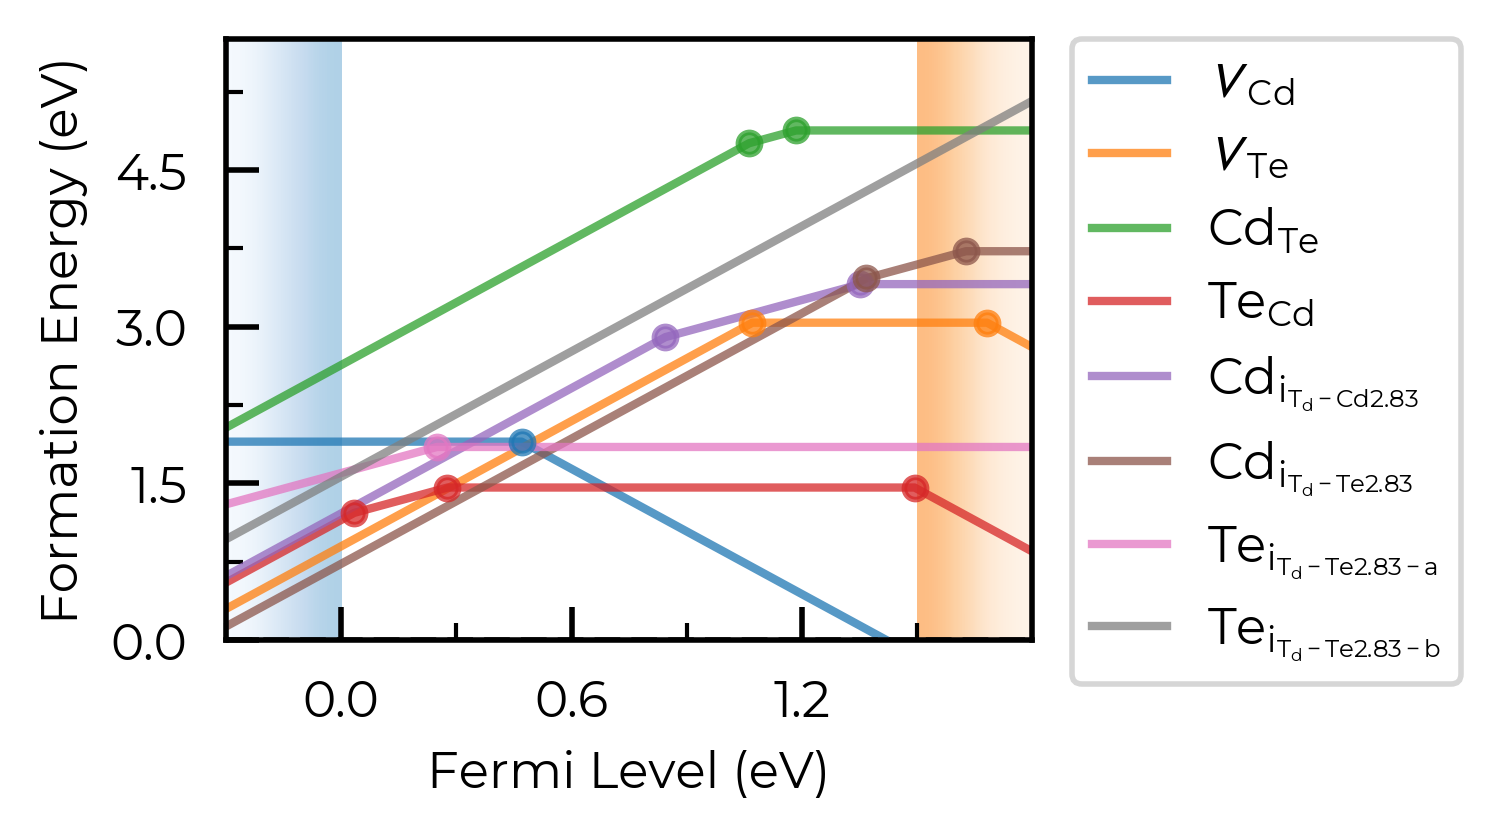

In [2]:
fig = CdTe_thermo.plot(limit="Te-rich")  # plot at the Te-rich chemical potential limit
fig

In [3]:
# run this cell to see the possible arguments for this function (or go to the python API documentation)
CdTe_thermo.plot?

### `dist_tol`

In the above plot, we see `doped` classified Te interstitials into having two separate defect sites. This is dictated by the `dist_tol` parameter in `DefectThermodynamics` (= 1.5 Å by default), which groups together defects which have distances between equivalent defect sites within this tolerance. 
In this case, this is because Te interstitials adopt [split-interstitial dimer structures](https://pubs.rsc.org/en/content/articlelanding/2022/fd/d2fd00043a) for the +1 and neutral charge states, but a different conventional interstitial type structure for the +2 charge state.  
We can see this if we use the `get_min_dist_between_equiv_sites` convenience function:

In [3]:
from doped.utils.symmetry import get_min_dist_between_equiv_sites

dist = get_min_dist_between_equiv_sites(CdTe_thermo["Te_i_Td_Te2.83_+2"], CdTe_thermo["Te_i_Td_Te2.83_0"])
print(f"Distance between Te_i +2 and 0 equivalent sites: {dist:.2f} Å")

Distance between Te_i +2 and 0 equivalent sites: 1.57 Å


Let's increase it to 1.6 Å here to group these Te interstitials together:

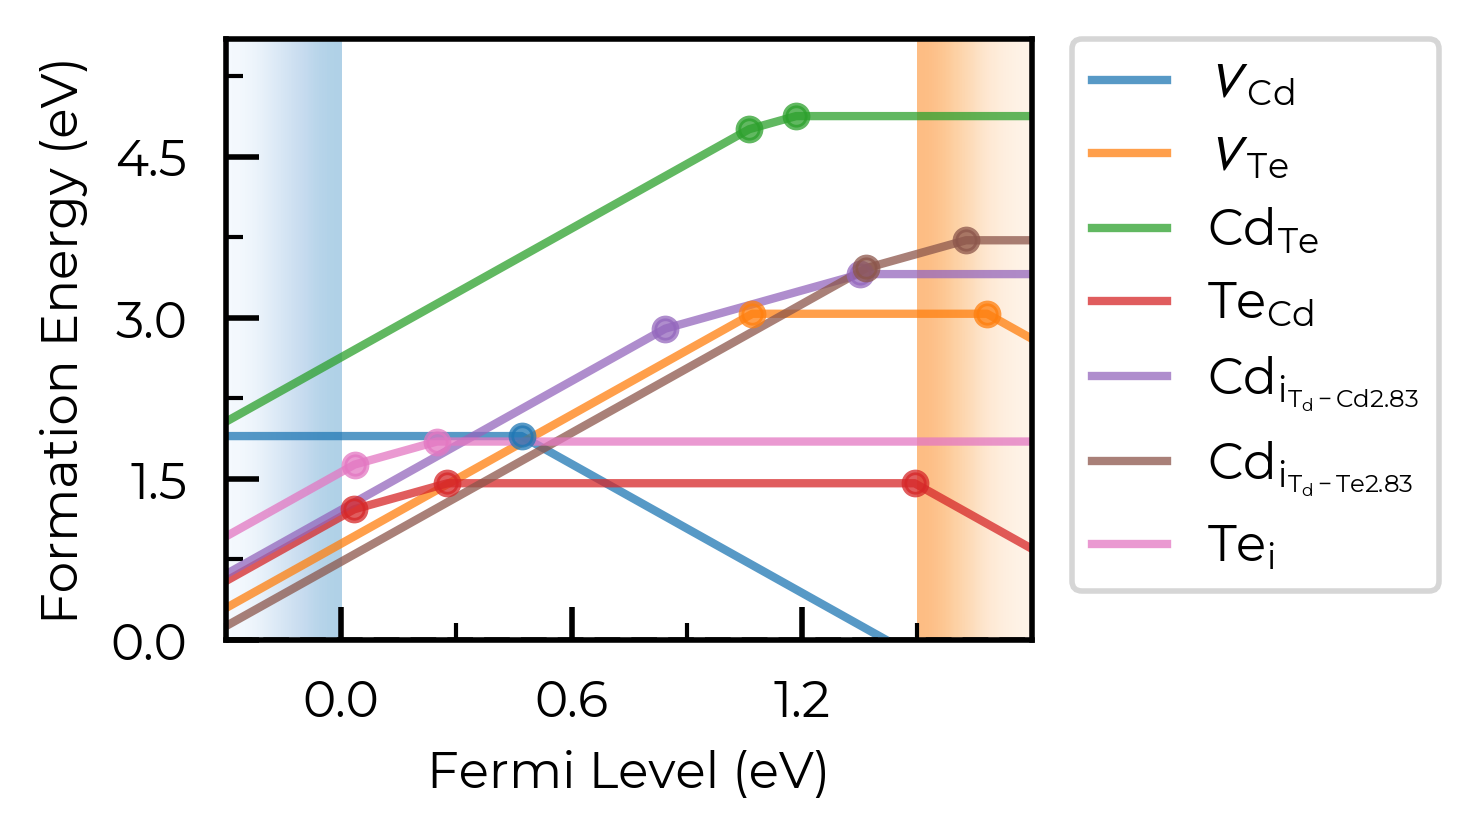

In [7]:
CdTe_thermo.dist_tol = 1.6
fig = CdTe_thermo.plot(limit="Te-rich")
fig

If we had many inequivalent defects in a system (e.g. in low-symmetry/complex systems such as [Sb₂Se₃](https://arxiv.org/abs/2402.04434)), we can set `dist_tol` to a high value to merge together these many inequivalent defects so that our formation energy plot just shows the lowest energy species of each defect type. Let's quickly look at monoclinic Sb₂O₅ ([a promising Sb(V)-based transparent conducting oxide](https://chemrxiv.org/engage/chemrxiv/article-details/65846b8366c1381729bc5f23), with several inequivalent sites) as an example case of this:

In [8]:
sb2o5_thermo = loadfn("../tests/data/Sb2O5/sb2o5_thermo.json.gz")  # load our pre-computed Sb2O5 DefectThermodynamics

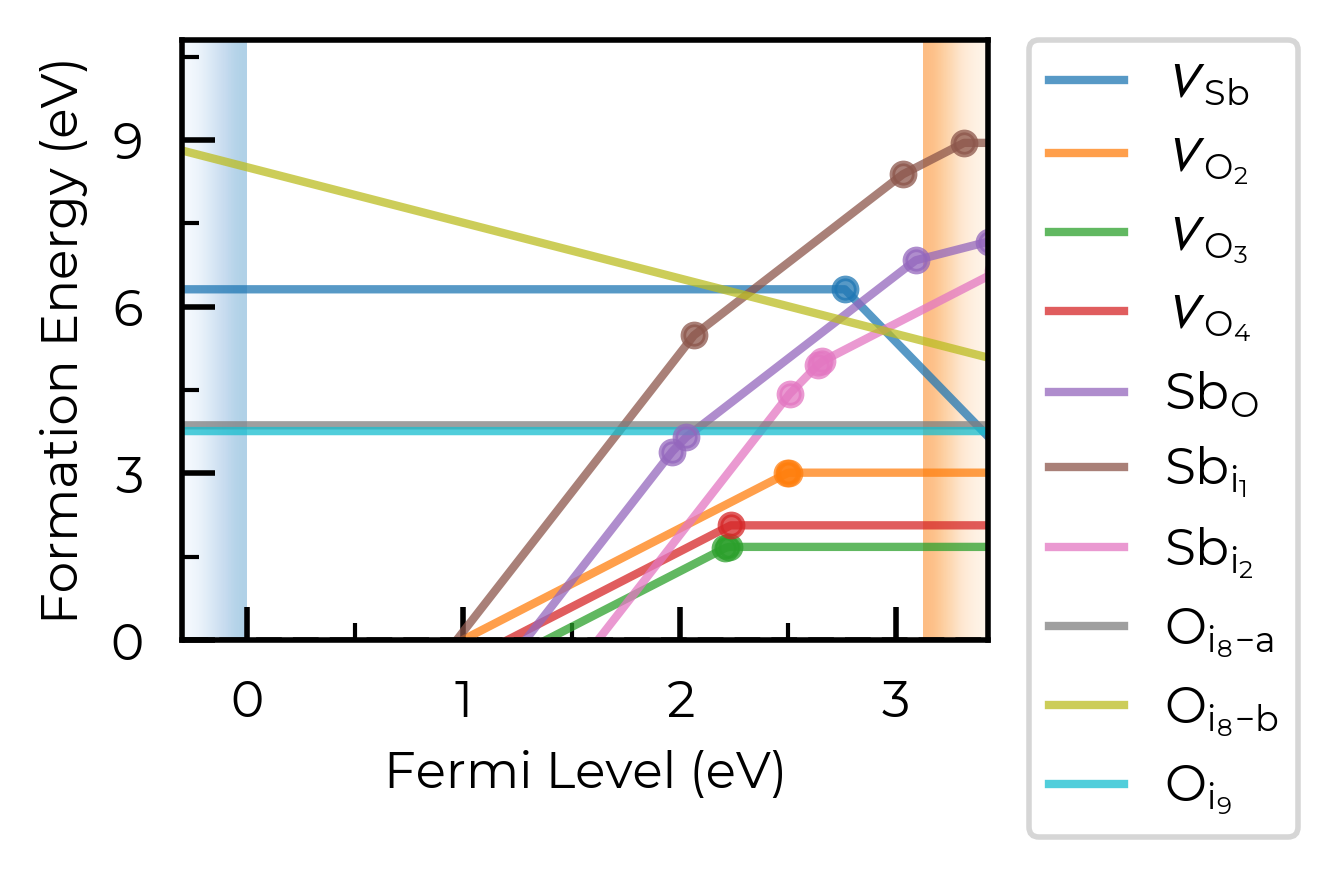

In [9]:
fig = sb2o5_thermo.plot(limit="O-poor")
fig

Let's set `dist_tol` to 2.5 , which will merge all inequivalent O interstitials and Sb interstitials in this case:

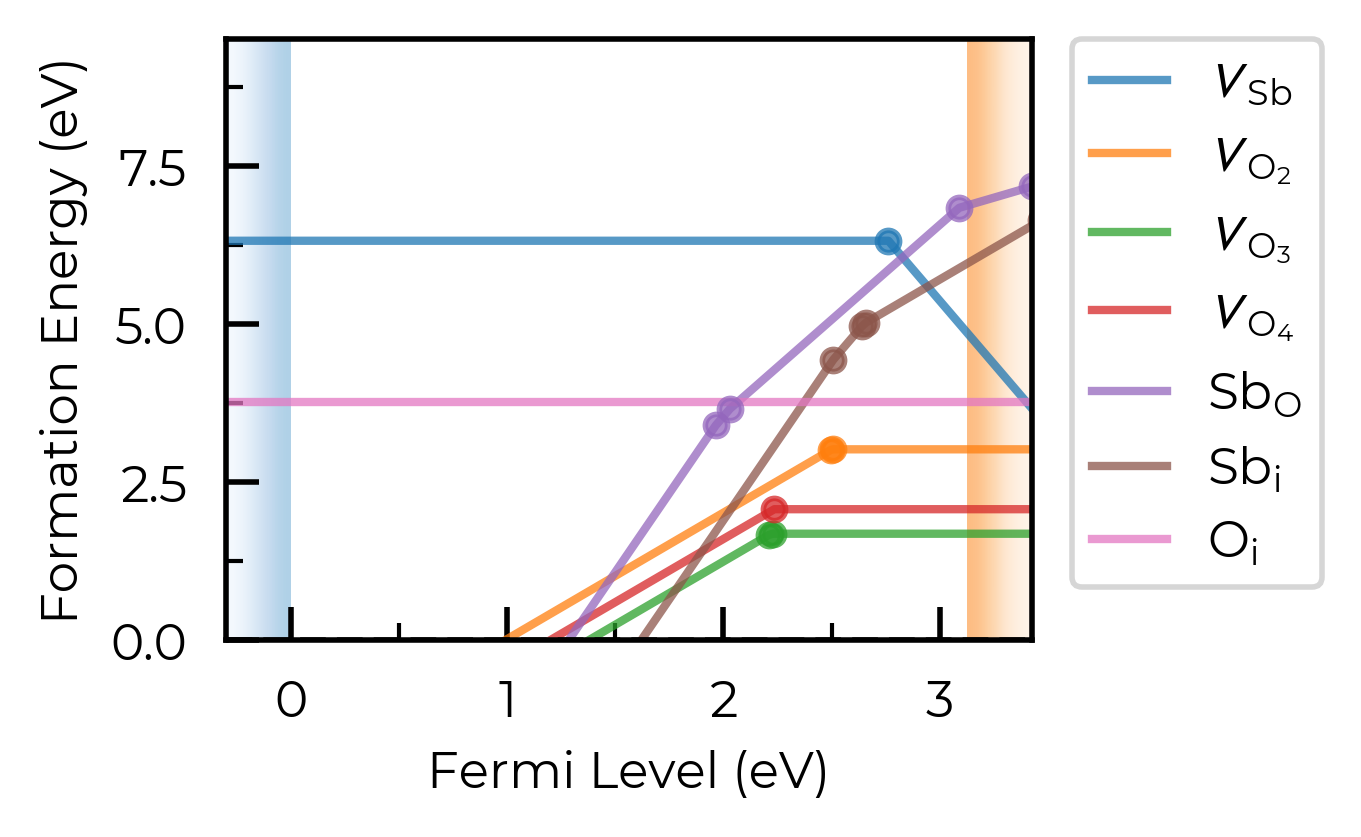

In [11]:
sb2o5_thermo.dist_tol = 2.5
fig = sb2o5_thermo.plot(limit="O-poor")
fig

If we set `dist_tol` even larger, to 3 Å here, this will merge all inequivalent O vacancies as well, so that only the lowest energy states are shown:

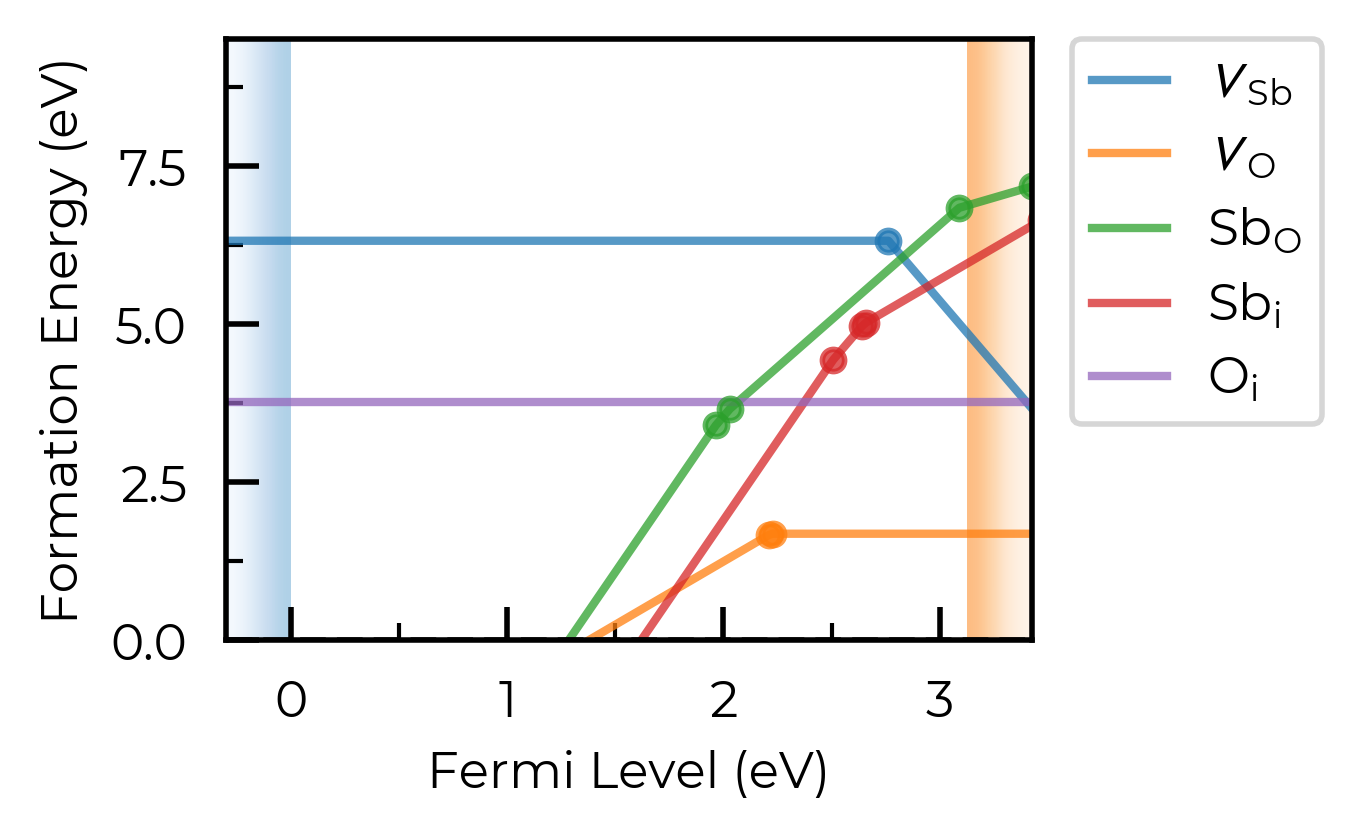

In [15]:
sb2o5_thermo.dist_tol = 3
fig = sb2o5_thermo.plot(limit="O-poor")
fig

```{note}
`dist_tol` is used to control the grouping together of different defect entries (different charge states, and/or ground and metastable states (different spin or geometries)) which correspond to the same defect type (e.g. interstitials at a given site), which are then used in plotting, transition level analysis and defect concentration calculations; e.g. in the frozen defect approximation, the total concentration of a given defect type group is calculated at the annealing temperature, and then the equilibrium relative population of the constituent entries is recalculated at the quenched temperature.

While large `dist_tol` values can be preferable for plotting (to condense the defect formation energy lines as shown in these examples), this is often not ideal for determining site competition in concentration analyses as it can lead to unrealistically-large clusters, so it is recommended to reset `dist_tol` to a reasonable value (~1-2 Å) before performing concentration analyses.
```

### `all_entries`

We can set `all_entries = True` to show the full formation energy lines for all defect species, not just the lowest energy charge states. This can be useful for analysing metastable defect states, but can also be quite messy when we are plotting many defects at once. 
For this case, let's trim down to just the Cd vacancy defects:

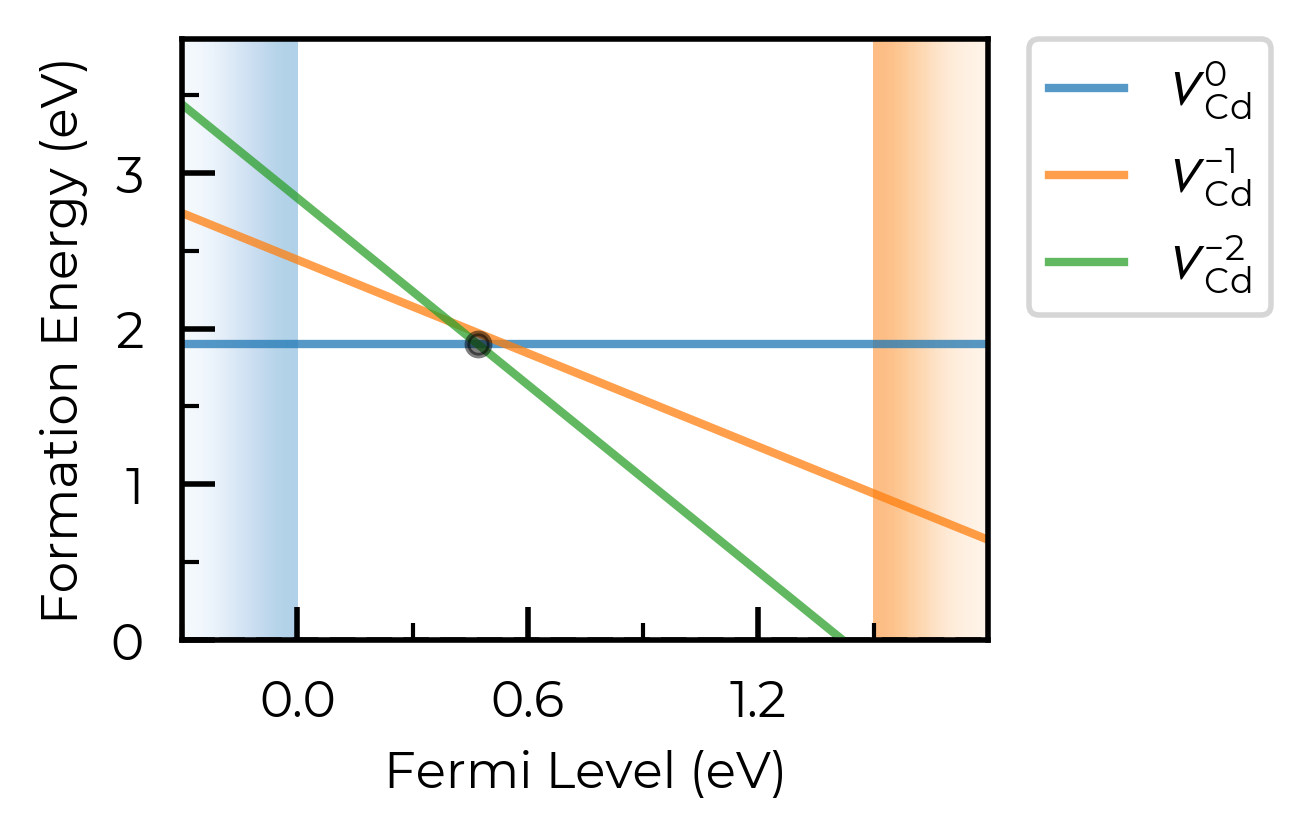

In [8]:
from doped.thermodynamics import DefectThermodynamics
v_Cd_thermo = DefectThermodynamics(
    [entry for name, entry in CdTe_thermo.defect_entries.items() if "v_Cd" in name],
    chempots=CdTe_thermo.chempots
)  # only Cd vacancy defects

fig = v_Cd_thermo.plot(all_entries=True, limit="Te-rich")
fig

We can instead set `all_entries = "faded"` to show the full formation energy lines for all defect species, but with all metastable states faded out in grey:

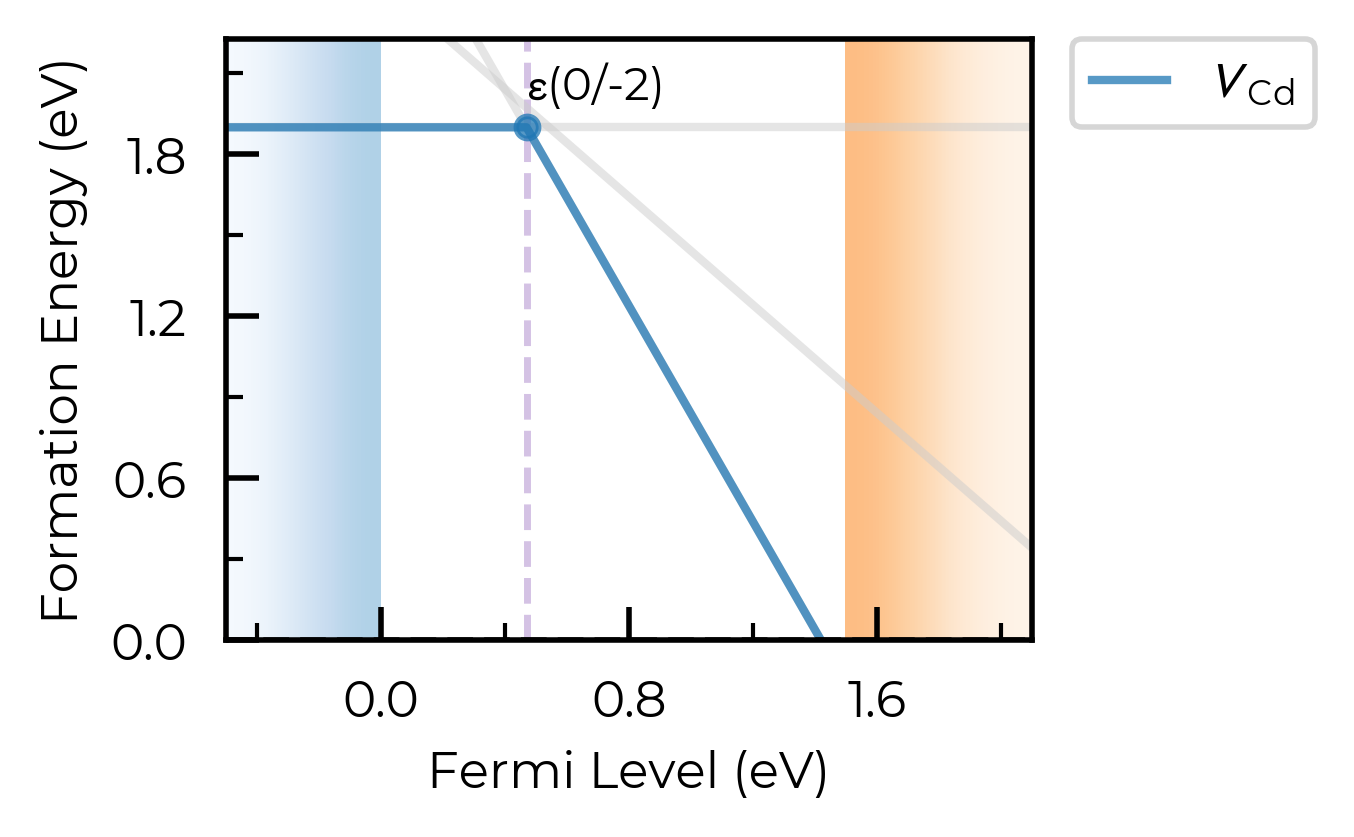

In [9]:
fig = v_Cd_thermo.plot( 
    auto_labels=True,
    xlim=(-0.5, 2.1),
    all_entries="faded",
    limit="Te-rich",
)
ax = fig.gca()
ax.axvline(0.47, ls="--", c="C4", alpha=0.4, zorder=-1)  # add a vertical line at the transition level
fig

### `chempots` & `el_refs`

We can also set the chemical potentials to be used in the plot directly in the plotting function (or can of course adjust `DefectThermodynamics.chempots/el_refs` directly):

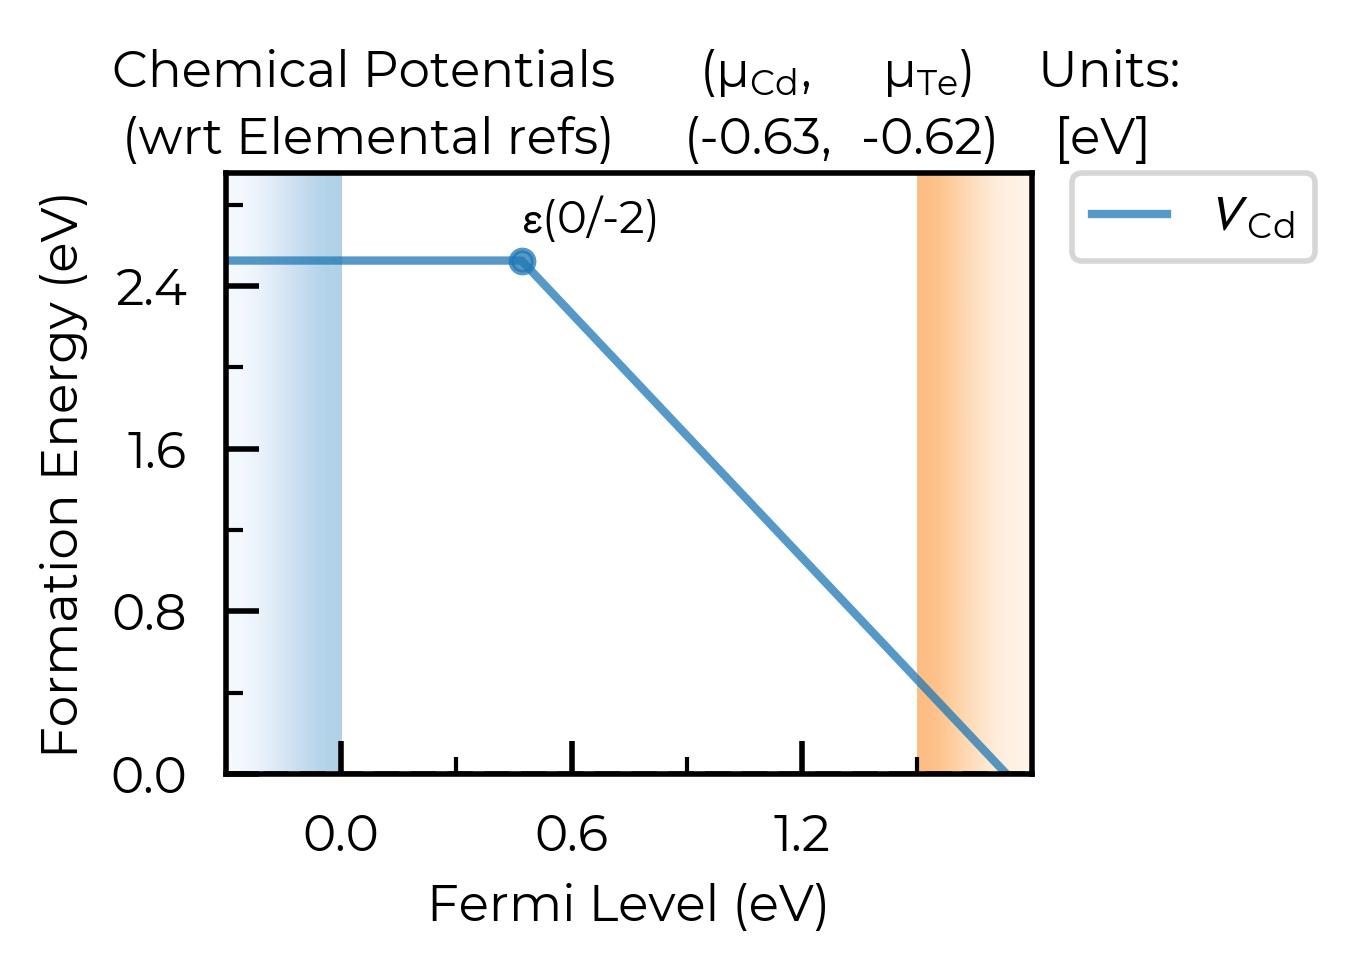

In [10]:
# we can always set/overwrite `chempots` in the plotting/tabulation functions like this too:
fig = v_Cd_thermo.plot(
    chempots = {"Cd": -0.6255, "Te": -0.625},  # midpoint between Te/Cd-rich  
    el_refs=CdTe_thermo.chempots.get("elemental_refs"),
    auto_labels=True,
    chempot_table=True,  # set this to True to show the chempots being used!
)
fig

### `limit`

The `limit` parameter specifies the chemical potential limit for which to
plot formation energies. This can be either:
- `None`, in which case plots are generated for all limits in ``chempots``.
- "X-rich"/"X-poor" where X is an element in the system, in which case the most X-rich/poor limit will be used (e.g. "Li-rich").
- A key in the ``(DefectThermodynamics.)chempots["limits"]`` dictionary.

The latter two options can only be used if ``chempots`` is in the `doped` format (see chemical potentials tutorial). 

In [11]:
# print the chemical potential limits
print(CdTe_thermo.chempots["limits"].keys())

dict_keys(['Cd-CdTe', 'CdTe-Te'])


In this case, we can plot the Cd-rich limit by setting `limit="Cd-rich"`, `limit="Cd-CdTe"` (the Cd-rich limit here) or by just manually setting the chemical potentials to this limit:

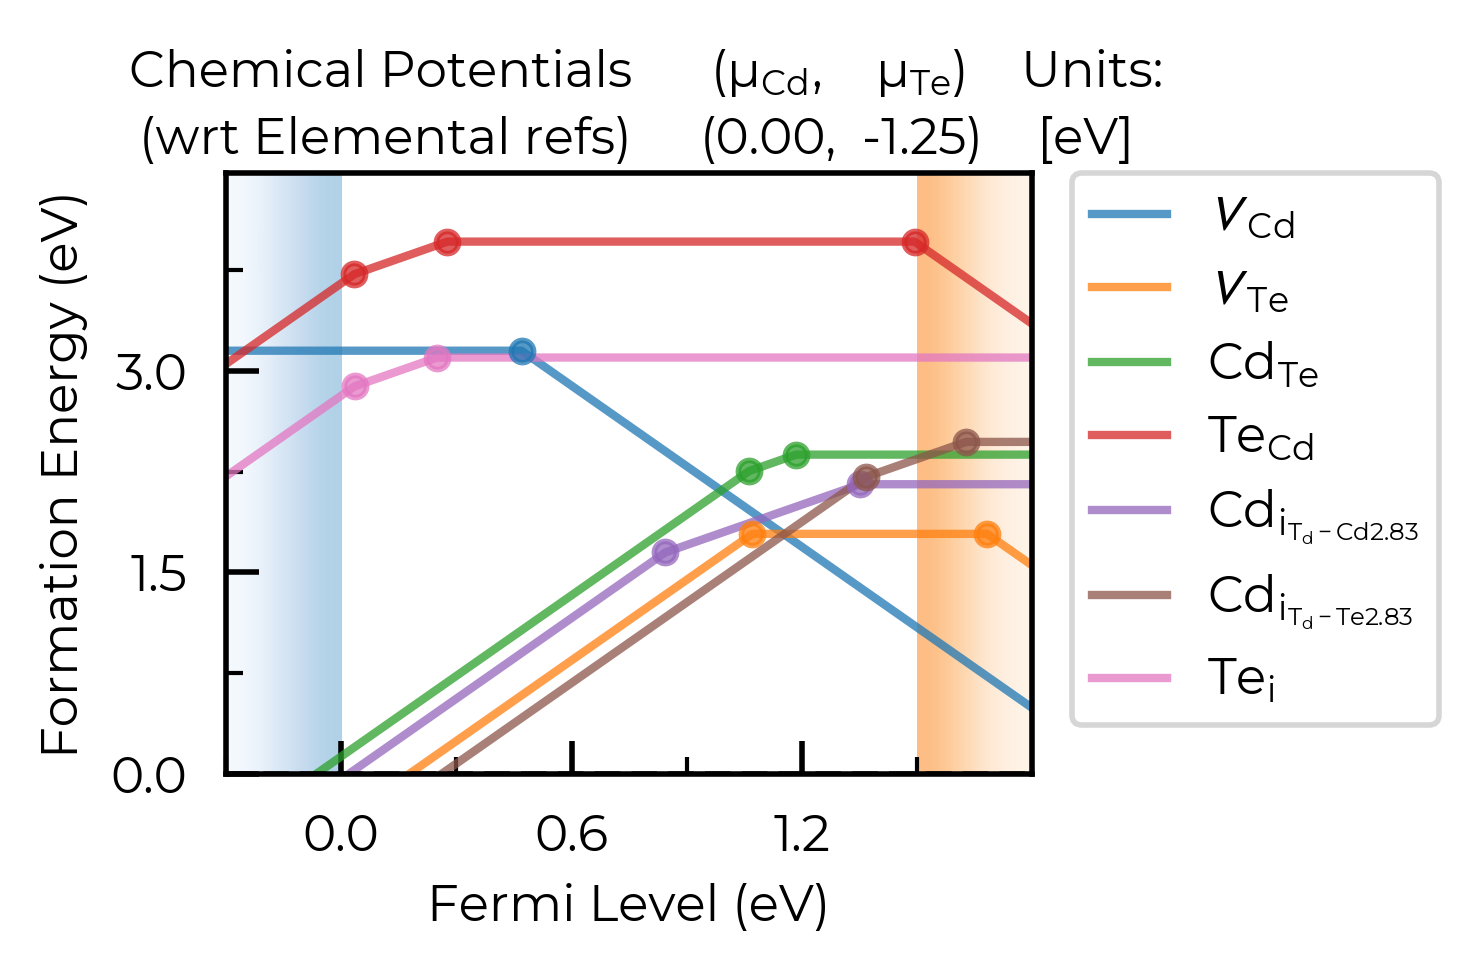

In [12]:
fig = CdTe_thermo.plot(limit="Cd-CdTe", chempot_table=True)
fig

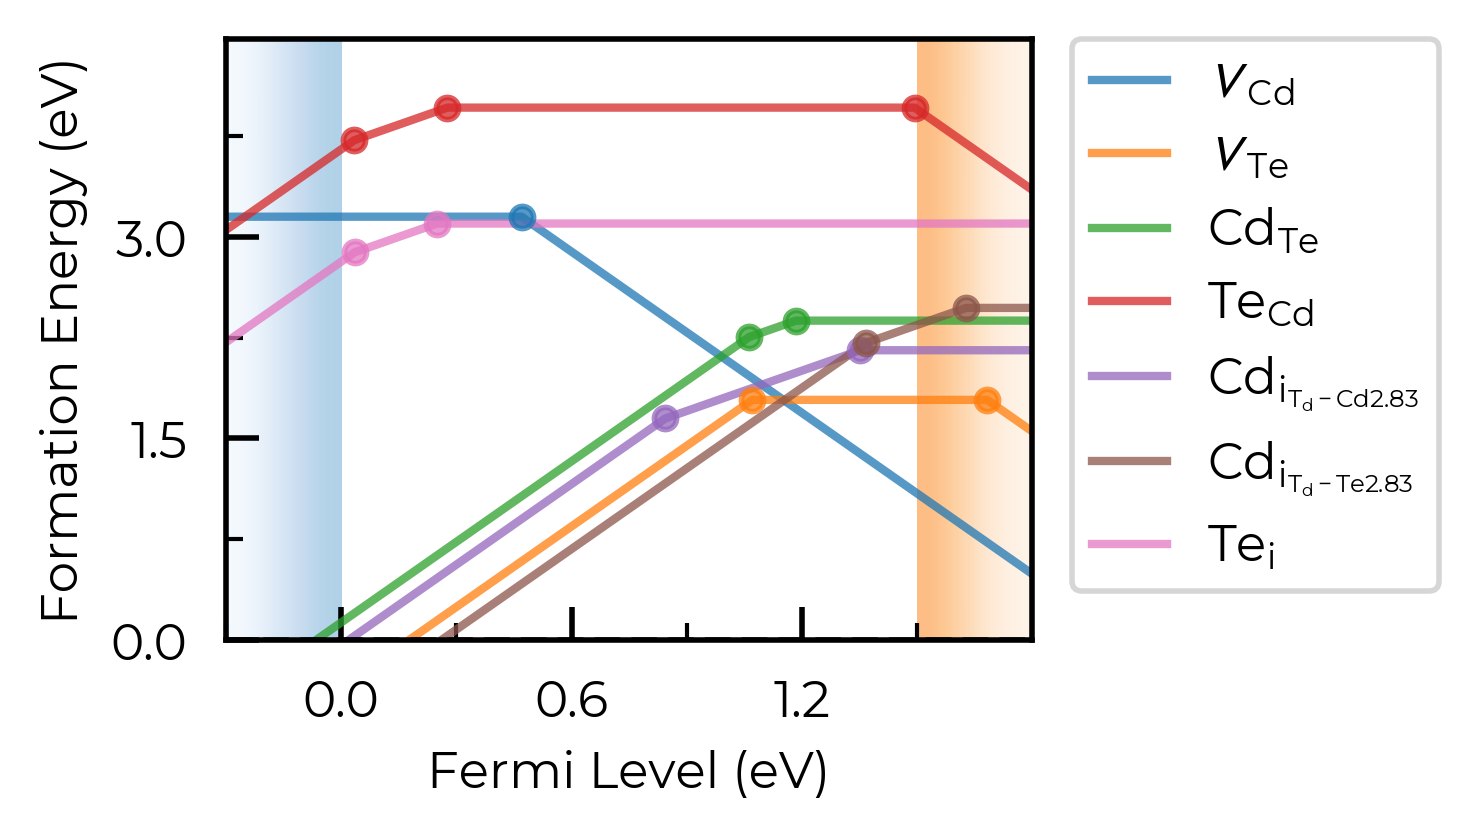

In [13]:
# manual Cd-rich chempots:
fig = CdTe_thermo.plot(
    chempots=CdTe_thermo.chempots["limits_wrt_el_refs"]["Cd-CdTe"],
    el_refs=CdTe_thermo.chempots["elemental_refs"]
)
fig

### `unstable_entries`

We can use the ``unstable_entries`` argument to control the plotting or omission of shallow ('perturbed host') and unstable defect charge states. See the [Electronic Structure Analysis](https://doped.readthedocs.io/en/latest/Tips.html#eigenvalue-electronic-structure-analysis) section of the `doped` Tips page for more info on shallow defect states.
The default setting is ``unstable_entries = "not shallow"``, meaning entries which are
detected to be shallow ('perturbed host') states and unstable for Fermi levels in the band gap are omitted from plotting for clarity & accuracy.

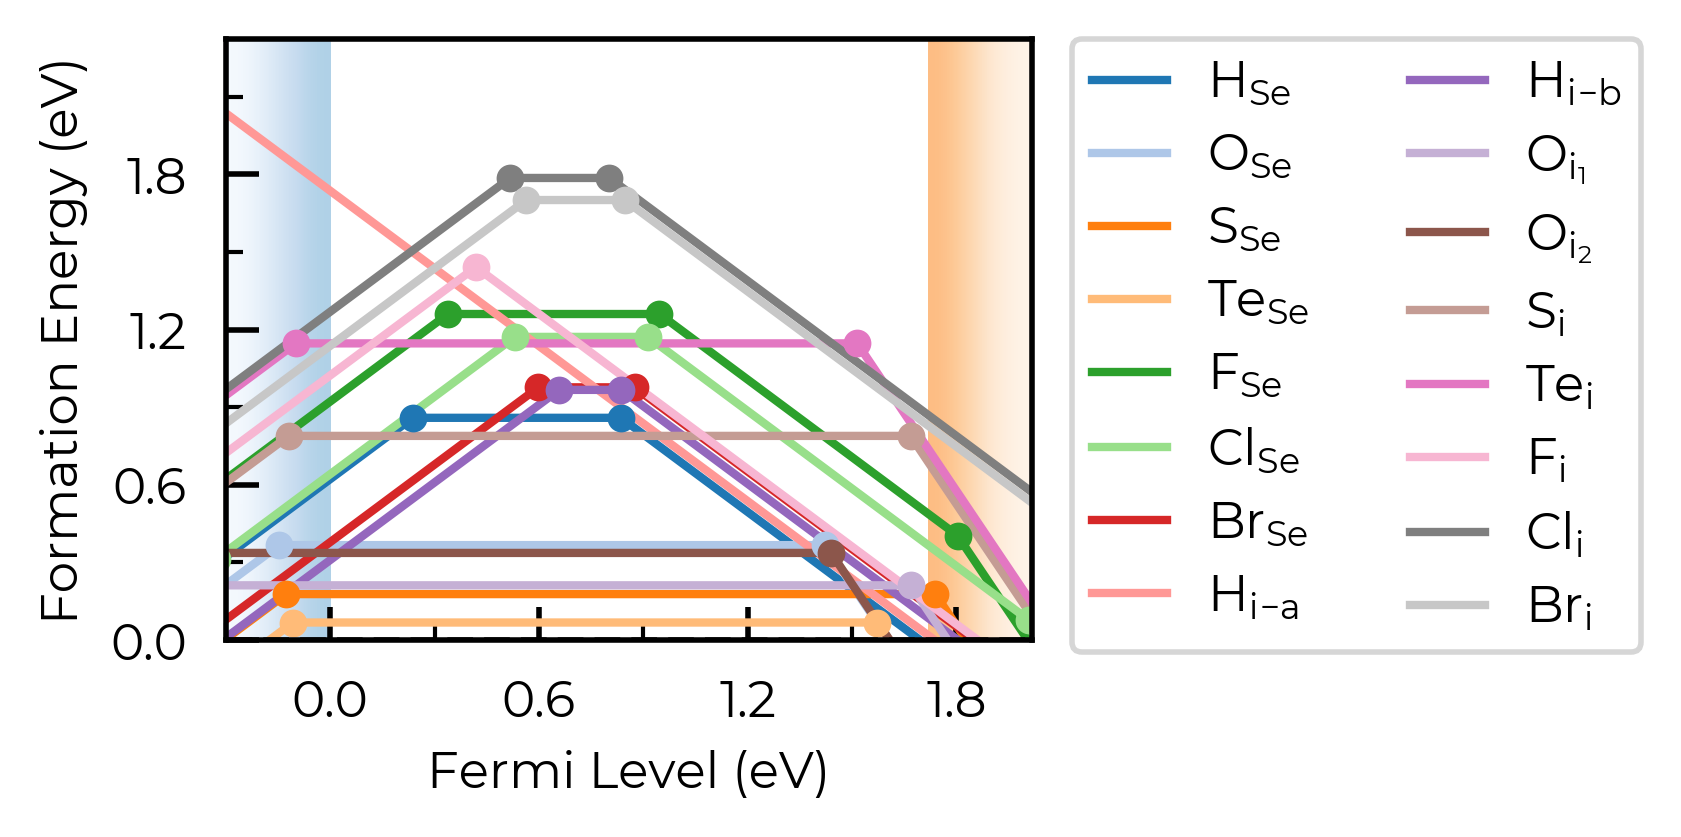

In [14]:
from doped.thermodynamics import DefectThermodynamics
Se_extrinsic_thermo = DefectThermodynamics.from_json(  # load our DefectThermodynamics object
    "../tests/data/Se_Ext_No_Pnict_Thermo.json.gz")

fig = Se_extrinsic_thermo.plot(unstable_entries=True)  # no pruning of shallow/unstable states
fig

We can see with the default ``unstable_entries="not shallow"`` below here, some +1 charge states for chalcogen substitutions/interstitials (from this [paper on defects in Selenium](https://doi.org/10.26434/chemrxiv-2024-91h02)) are now omitted, being unstable for in-gap Fermi levels and having been automatically detected as shallow defects by `doped`'s eigenvalue analysis:

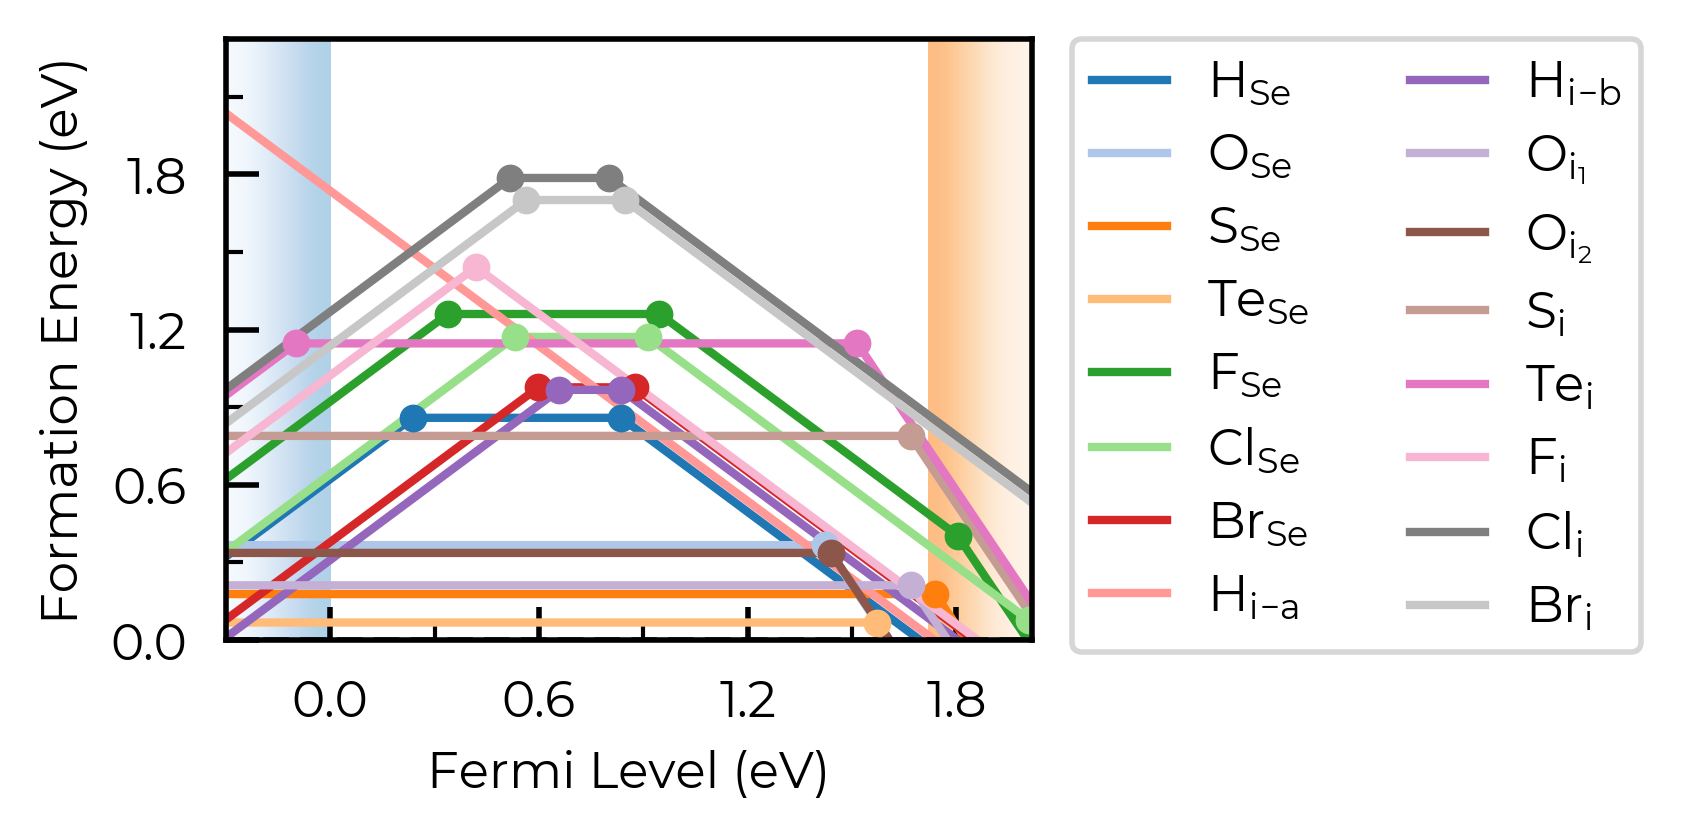

In [15]:
fig = Se_extrinsic_thermo.plot(unstable_entries="not shallow")  # default
fig

In [16]:
Se_extrinsic_thermo["sub_1_O_on_Se_1"].is_shallow  # confirm shallow classification

True

See the [API docs](https://doped.readthedocs.io/en/latest/doped.thermodynamics.html#doped.thermodynamics.DefectThermodynamics.plot) / docstring for more info on the available ``unstable_entries`` choices!

### `colormap`

We can set different (qualitative) colour maps for the plots. This can be a string name of a `Matplotlib` colormap (see [here](https://matplotlib.org/stable/users/explain/colors/colormaps.html#qualitative)), or a `Colormap` object:

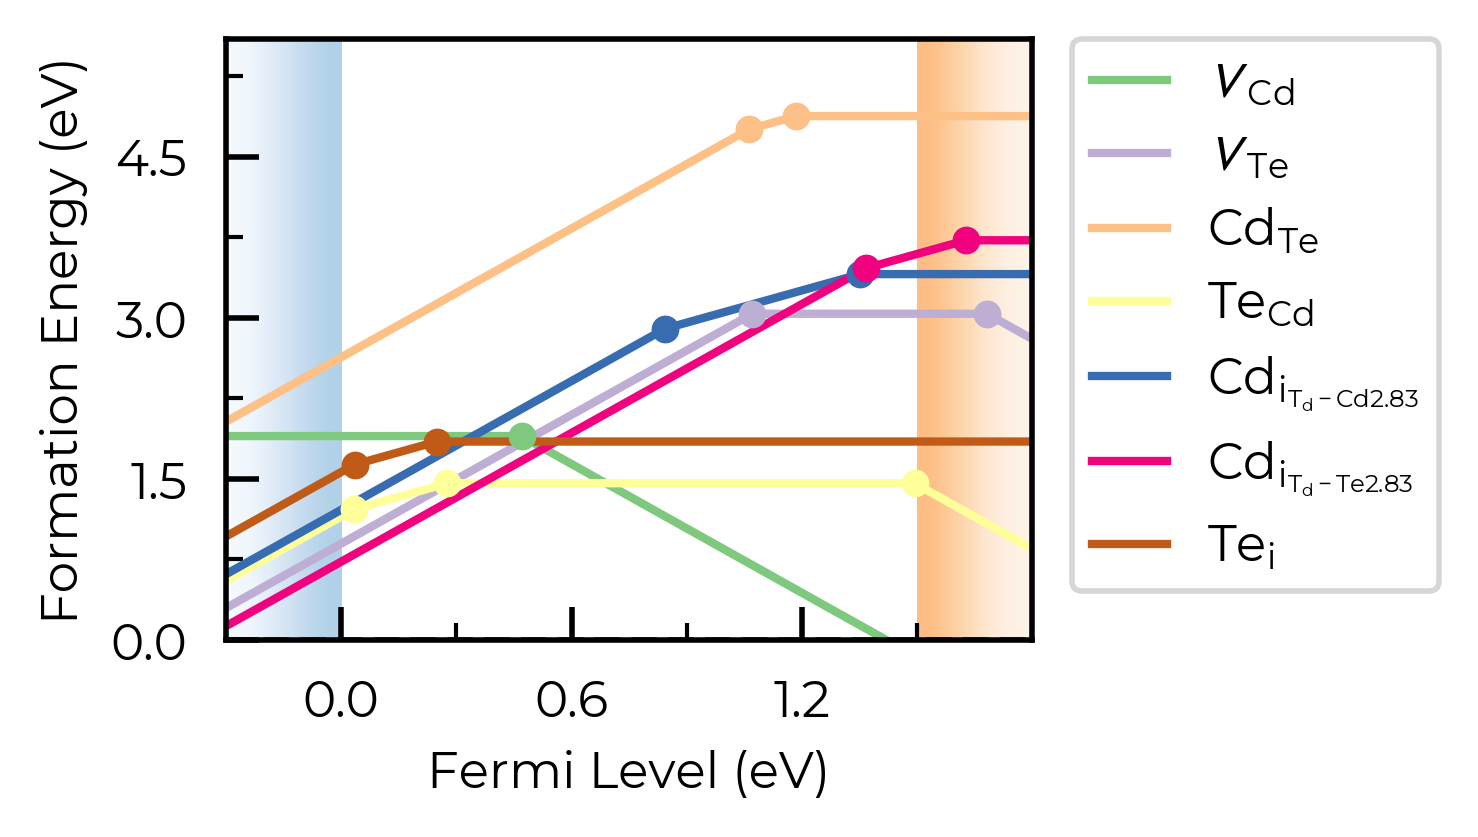

In [17]:
fig = CdTe_thermo.plot(limit="Te-rich", colormap="Accent")
fig

In [18]:
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#D4447E", "#E9A66C", "#507BAA", "#5FABA2", "#63666A", "#A3A3A3", "#FFD700"])

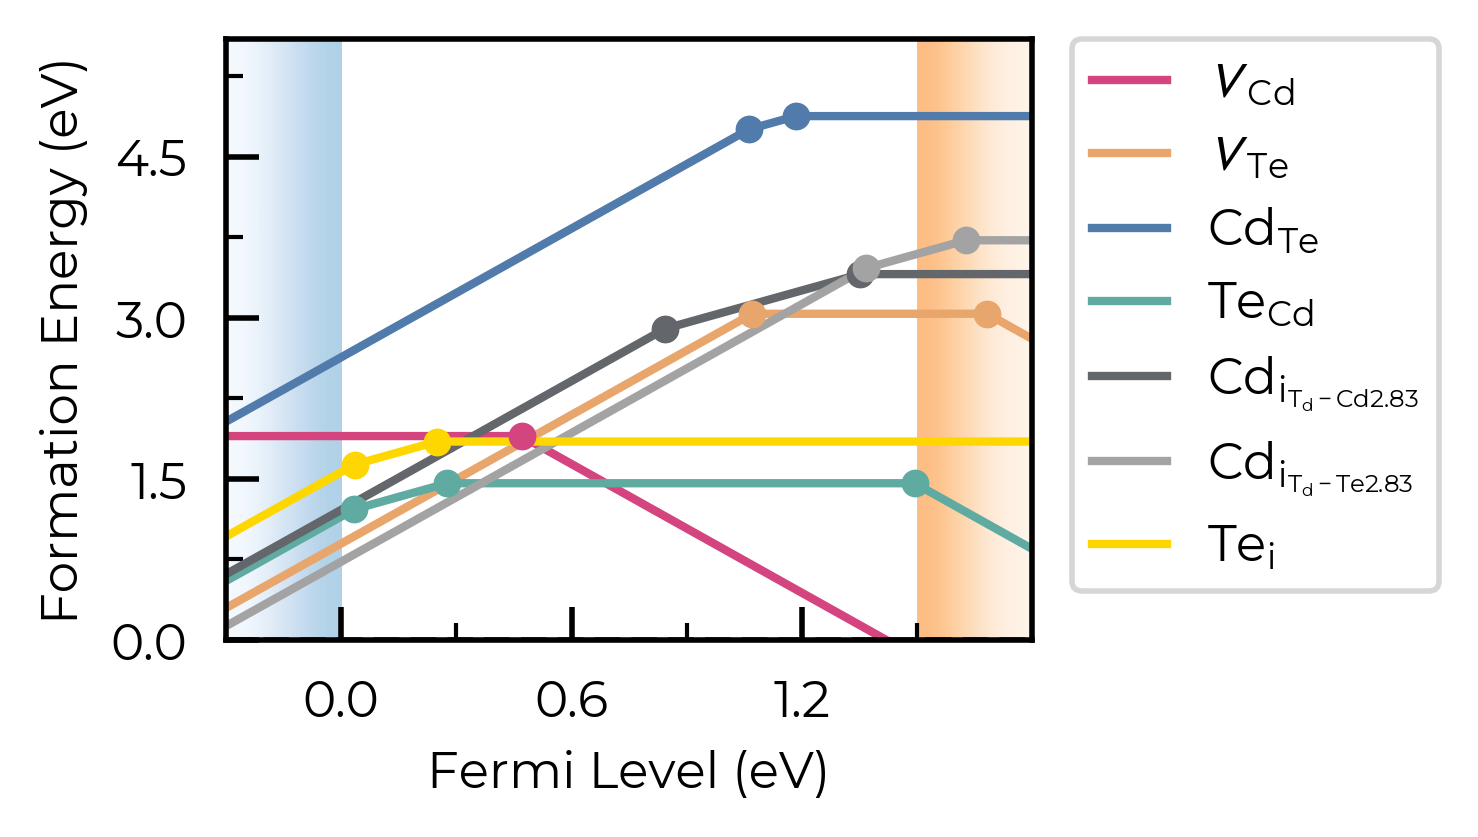

In [19]:
fig = CdTe_thermo.plot(limit="Te-rich", colormap=custom_cmap)
fig

### `linestyles` (and `dist_tol`, `colormap`)

In this example, we plot the formation energies of impurity elements as interstitials in trigonal Selenium -- a [promising candidate for indoor and tandem PV, investigated using `doped` & `ShakeNBreak`](https://doi.org/10.26434/chemrxiv-2024-91h02): 

In [20]:
from doped.thermodynamics import DefectThermodynamics
Se_extrinsic_thermo = DefectThermodynamics.from_json(
    "Se/Se_Amalgamated_Extrinsic_Thermo.json.gz"
)  # load our DefectThermodynamics object

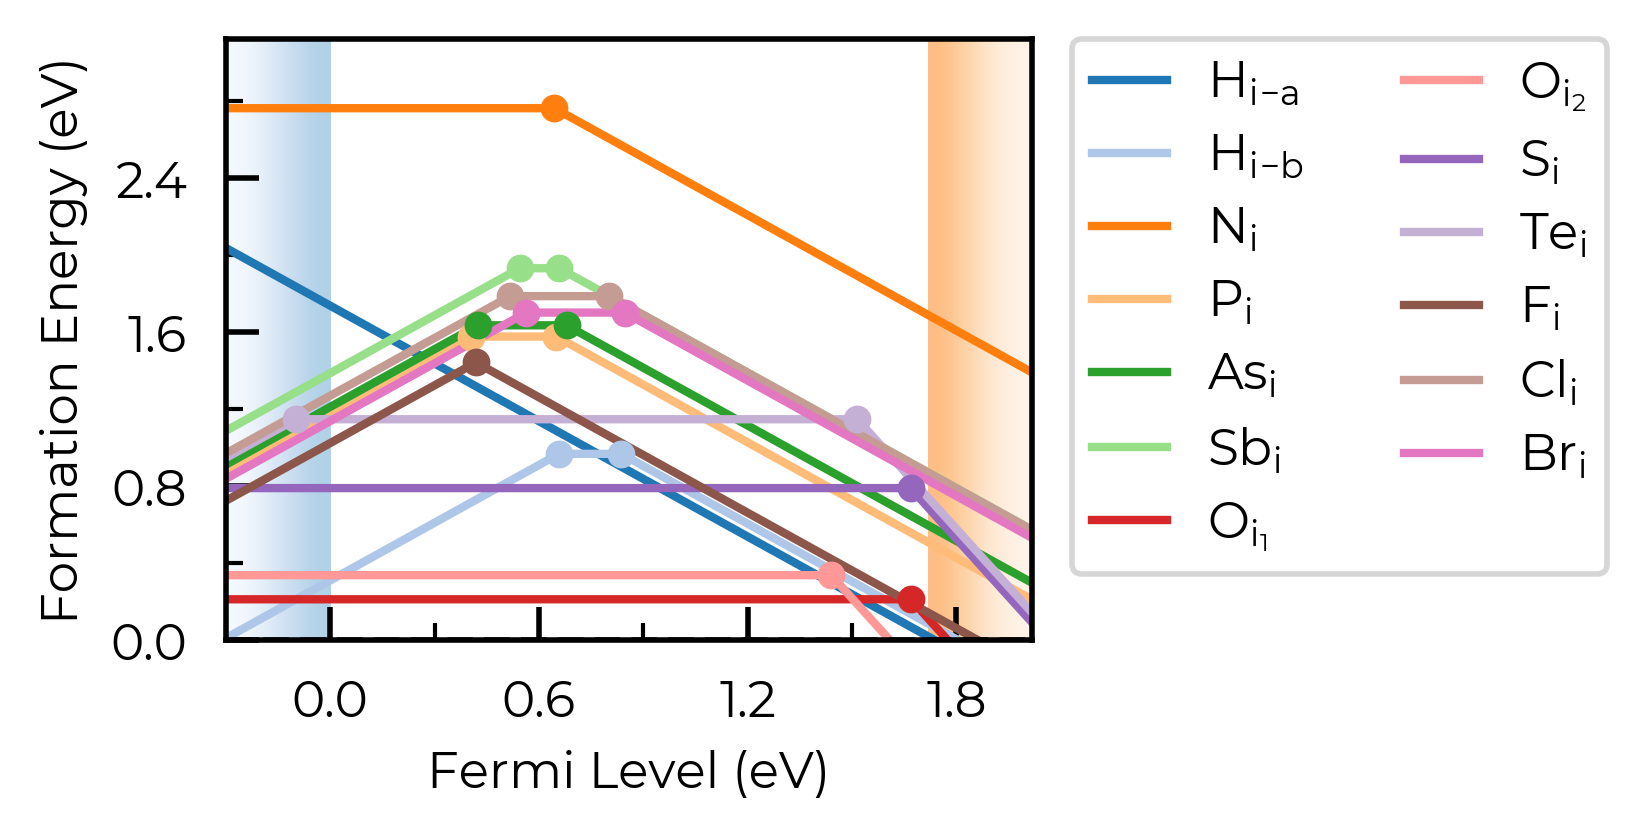

In [21]:
# interstitials only first:
from doped.core import Interstitial
Se_extrinsic_interstitials_thermo = DefectThermodynamics(
    defect_entries=[entry for entry in Se_extrinsic_thermo.defect_entries.values()
                    if isinstance(entry.defect, Interstitial)],
    chempots = Se_extrinsic_thermo.chempots,
)
fig = Se_extrinsic_interstitials_thermo.plot()
fig

Here, we have two nearby-but-distinct interstitial sites for hydrogen and oxygen interstitials. For now, let's increase `dist_tol` to merge these together, and just show the lowest energy state for each distinct defect type: 

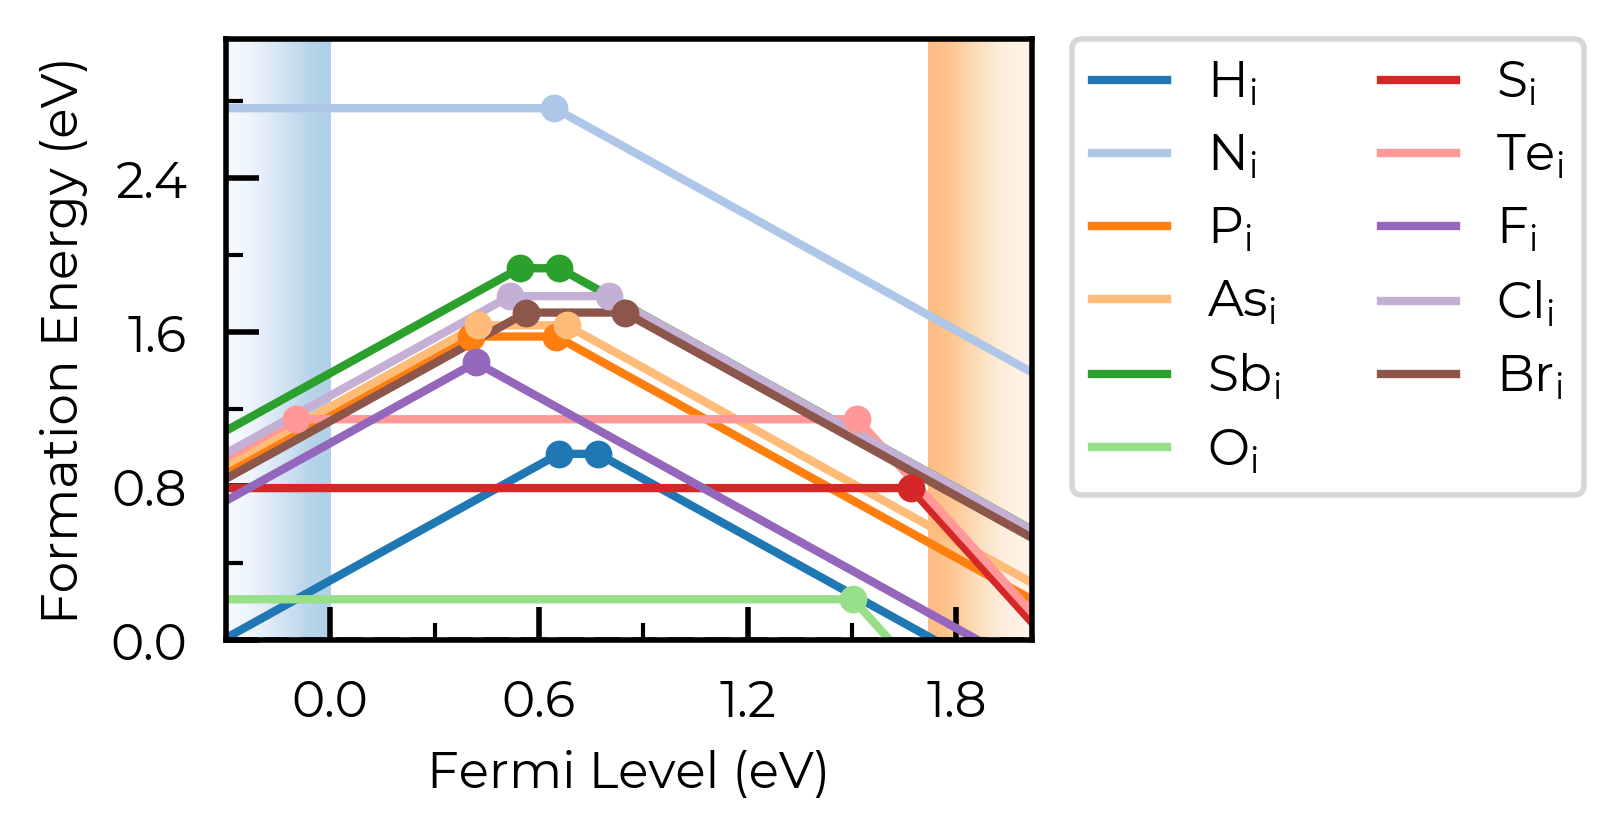

In [22]:
Se_extrinsic_interstitials_thermo.dist_tol = 2
fig = Se_extrinsic_interstitials_thermo.plot()
fig

Here, we have a number of consistent trends in behaviour for the impurities, as a function of periodic group and row (hydrogen vs pnictogens vs chalcogens vs halogens), so it would aid our analysis to group the defects together in this way. We can use the `colormap` and `linestyles` option to do this:

```{tip}
By default, defect entries in `DefectThermodynamics.defect_entries` (and thus plotting) are ordered by defect type (vacancies, substitutions, interstitials), then by order of appearance of the elements in the host composition, then by periodic group, then by atomic number (and then by charge state).
This is seen above, where the defects are ordered: H (group 1), N, P, As, Sb (group 15, descending), O, S, Te (group 16, descending), F, Cl, Br (group 17, descending). This makes plotting customisation based on periodic table positioning nice and easy, as shown below.
```


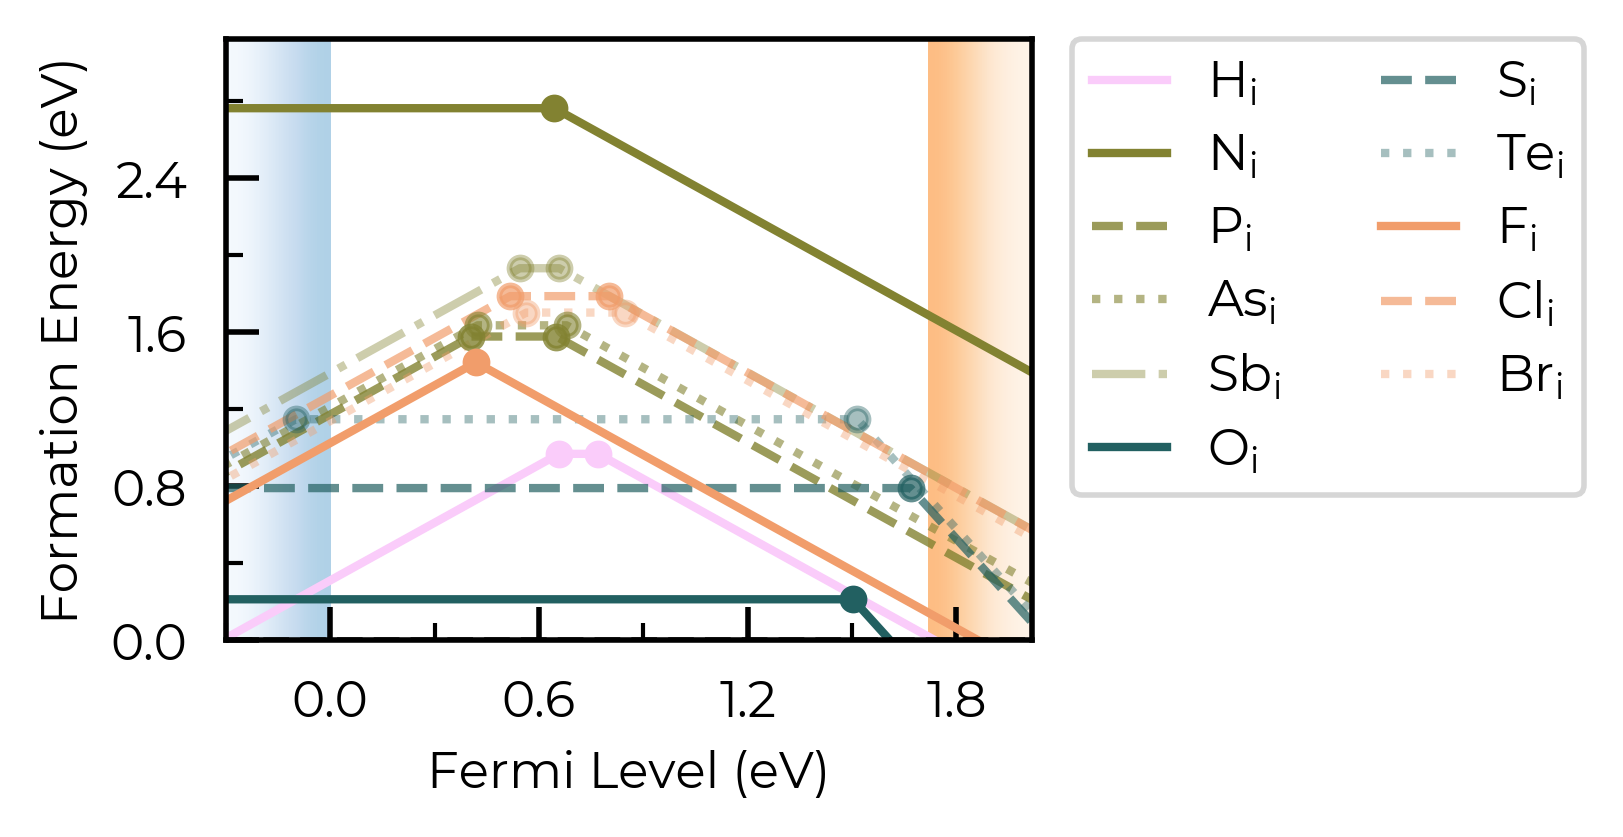

In [23]:
# order of defects in plot: H, N, P, As, Sb, O, S, Te, F, Cl, Br
from matplotlib.colors import ListedColormap
import cmcrameri.cm as cmc

# choose our colours for each periodic group:
colors = cmc.cmaps.get("batlowS").colors  # choose colormap (www.fabiocrameri.ch/colourmaps) 
H_color, pnict_color, chalc_color, halogen_color = colors[1:5]  # choose colors
H_pnict_chalc_halogen_colormap = ListedColormap(
    [H_color, # RGB color
     # here we also adjust the alpha value to decrease the opacity of each line as we
     # move down the periodic group:
    *[(*pnict_color, 1 - 0.2 * i) for i in range(4)],  # RGBA color (RGB + alpha)
    *[(*chalc_color, 1 - 0.3 * i) for i in range(3)],
    *[(*halogen_color, 1 - 0.3 * i) for i in range(3)],]
)
# choose linestyles
linestyles = [ # solid for first of each group, then dashed, dotted, dashdot
    "-",
    "-", "--", ":", "-.",
    "-", "--", ":", 
    "-", "--", ":"
]

fig = Se_extrinsic_interstitials_thermo.plot(
    colormap=H_pnict_chalc_halogen_colormap,
    linestyles=linestyles,
)
fig

Cool. Let's plot the substitutions like this too:

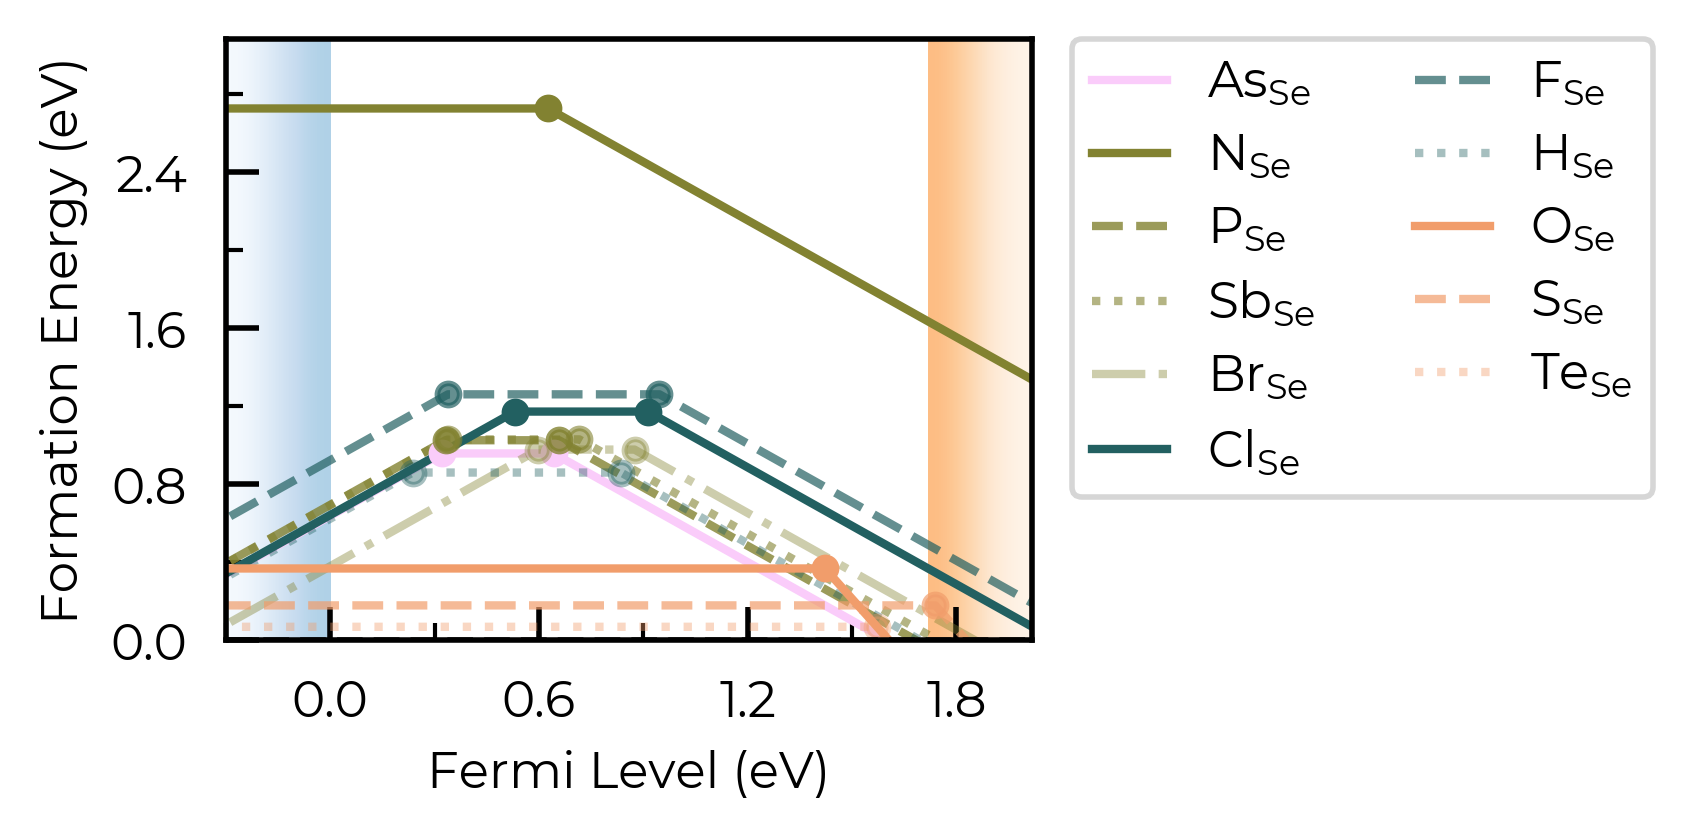

In [24]:
from doped.core import Substitution
Se_extrinsic_substitutions_thermo = DefectThermodynamics(
    defect_entries=[entry for entry in Se_extrinsic_thermo.defect_entries.values()
                    if isinstance(entry.defect, Substitution)],
    chempots = Se_extrinsic_thermo.chempots,
)
fig = Se_extrinsic_substitutions_thermo.plot(
    colormap=H_pnict_chalc_halogen_colormap,
    linestyles=linestyles,
)  # same number of defects to plot, so can use same colormap and linestyles
fig

### `style_file`

We can adjust the overall style of the plot by using a custom `matplotlib` style (`mplstyle`) file:

In [25]:
with open("custom_style.mplstyle", "w") as f:
    f.write("ytick.right : True\nxtick.top : True\nfont.sans-serif : Helvetica")

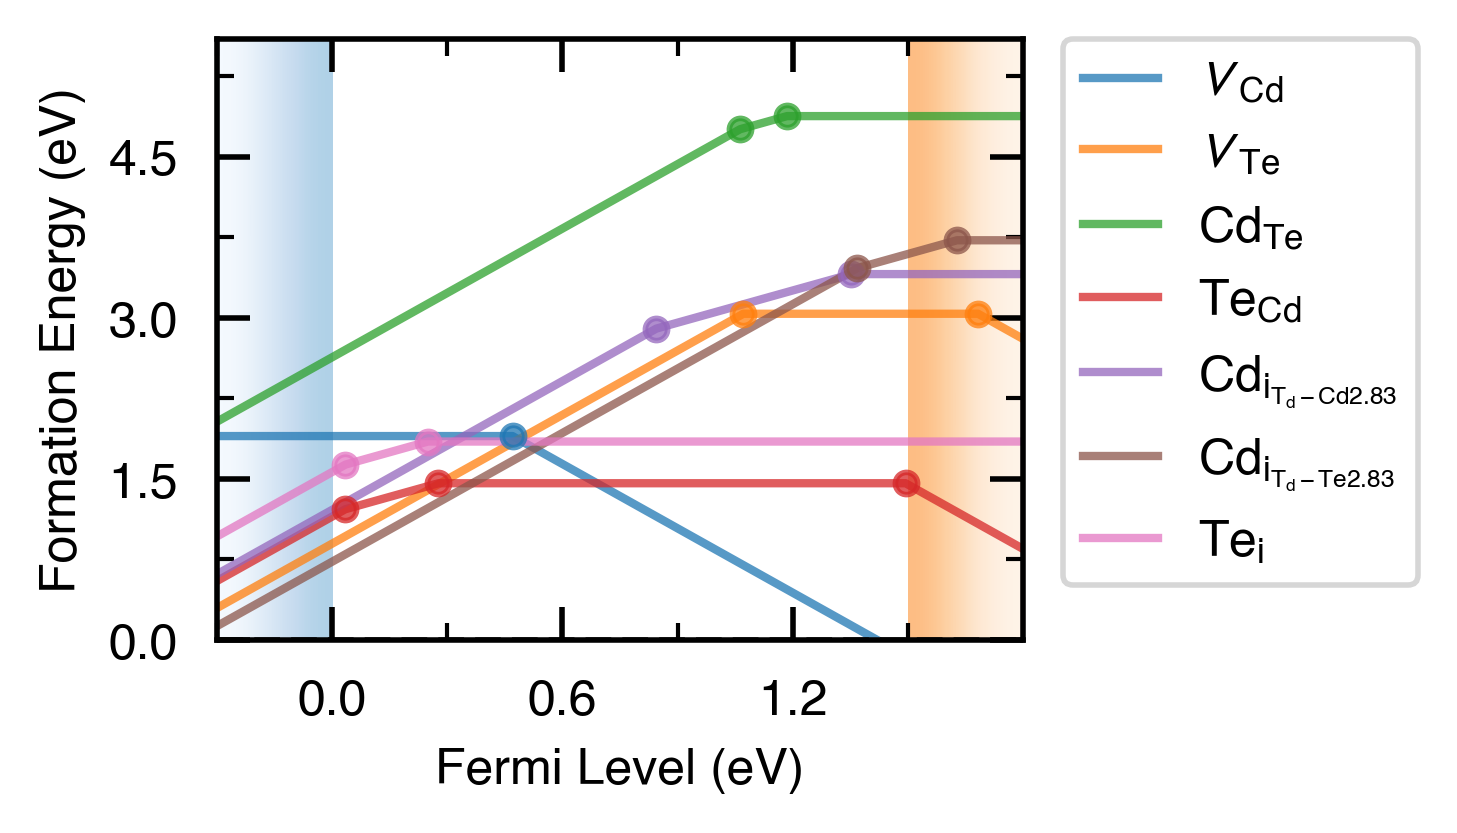

In [26]:
fig = CdTe_thermo.plot(limit="Te-rich", style_file="custom_style.mplstyle")
fig

### `auto_labels`

We can include automatic labels for the transition levels:
(as you can see, these get very messy when we are plotting many defects, so usually best to use only with a small number of defects)

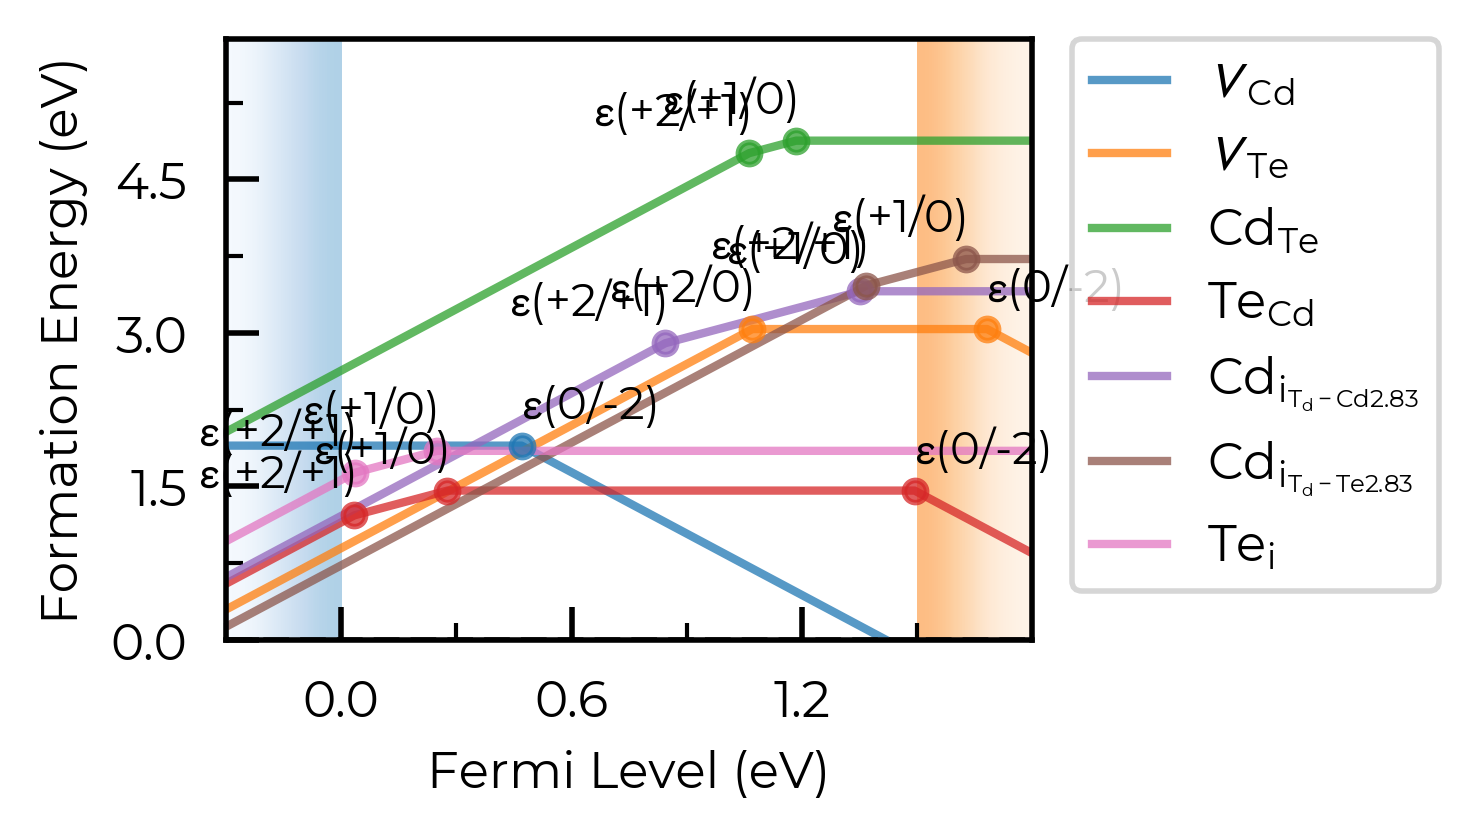

In [27]:
fig = CdTe_thermo.plot(limit="Te-rich", auto_labels=True)
fig

### `chempot_table`

We can control whether or not to show the chemical potentials above the plot, which can be useful when looking at behaviour under different chemical potential limits:

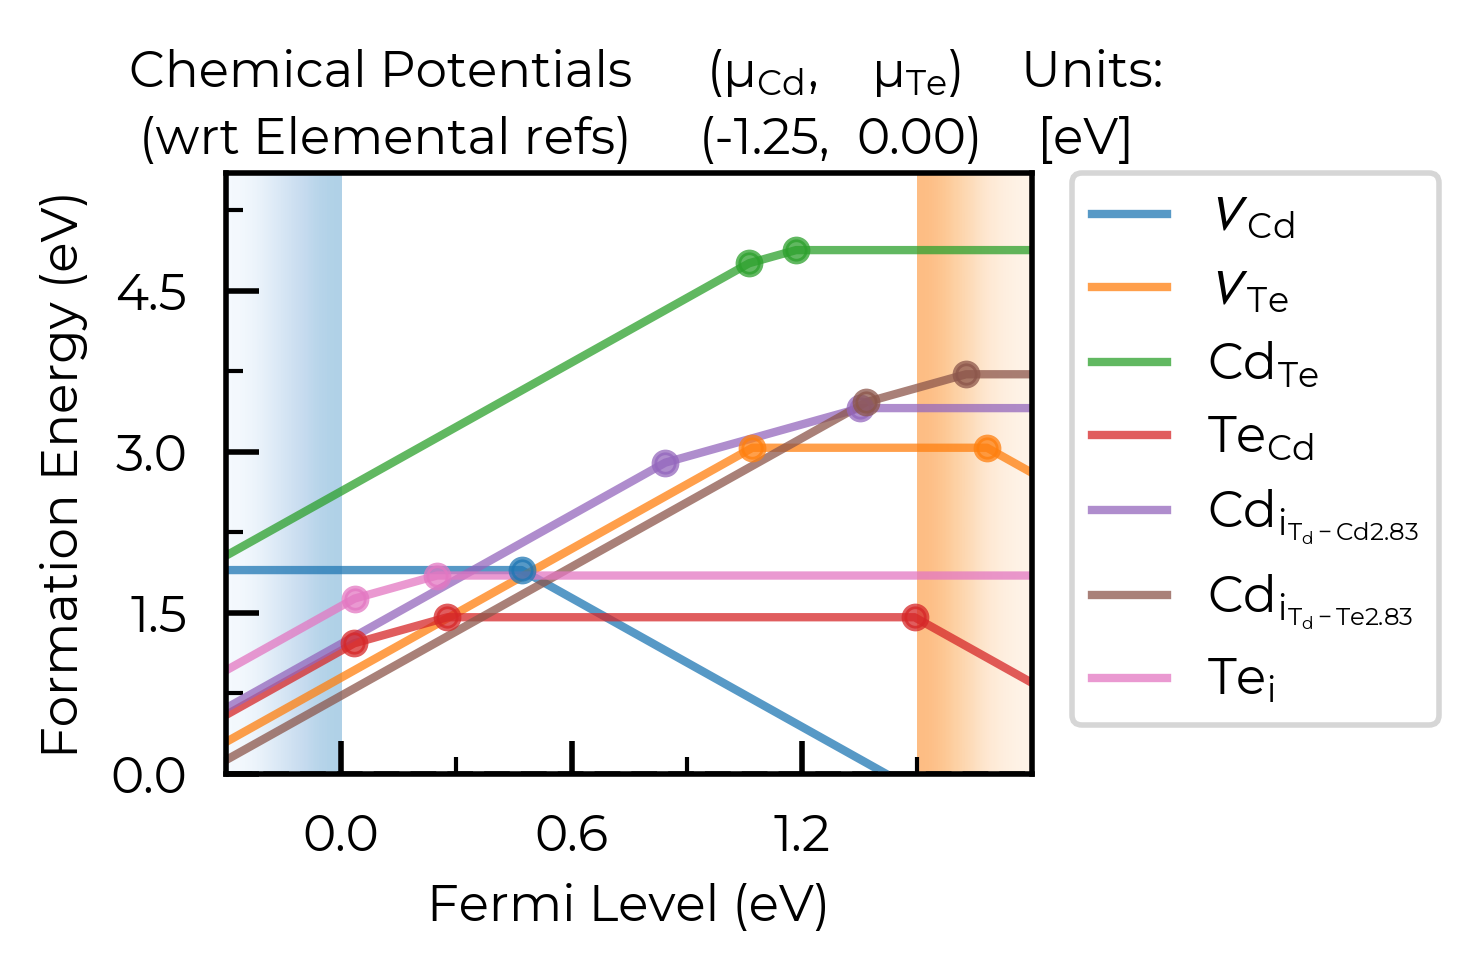

In [28]:
fig = CdTe_thermo.plot(limit="Te-rich", chempot_table=True)
fig

### `xlim` & `ylim`

We can adjust the axis limits:

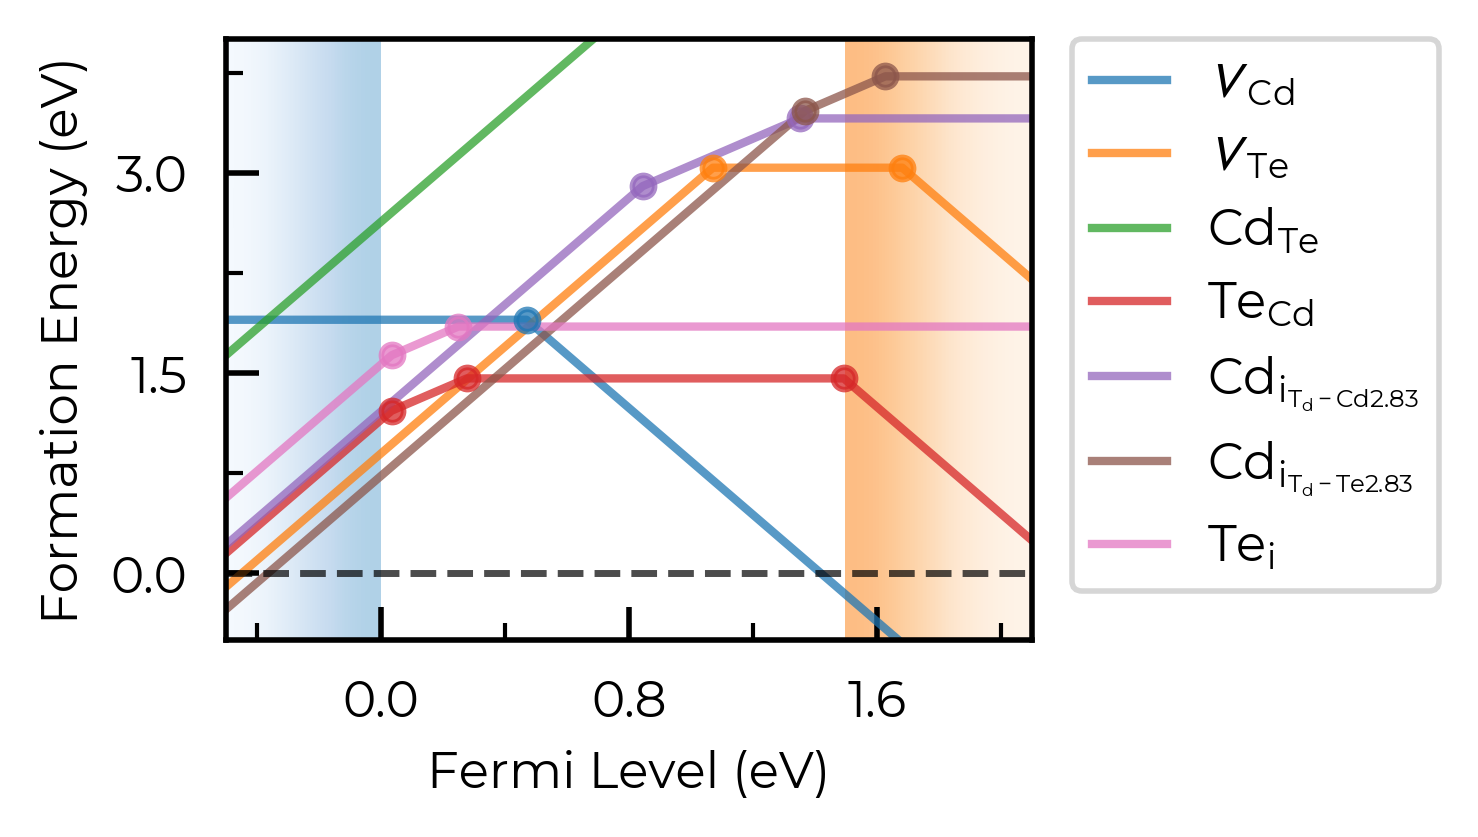

In [33]:
fig = CdTe_thermo.plot(limit="Te-rich", xlim=(-0.5, 2.1), ylim=(-0.5, 4.0))
fig

### `fermi_level`

We can show a vertical line at the predicted Fermi level position (see the `doped` thermodynamics tutorial for details on how we might go about doing this):

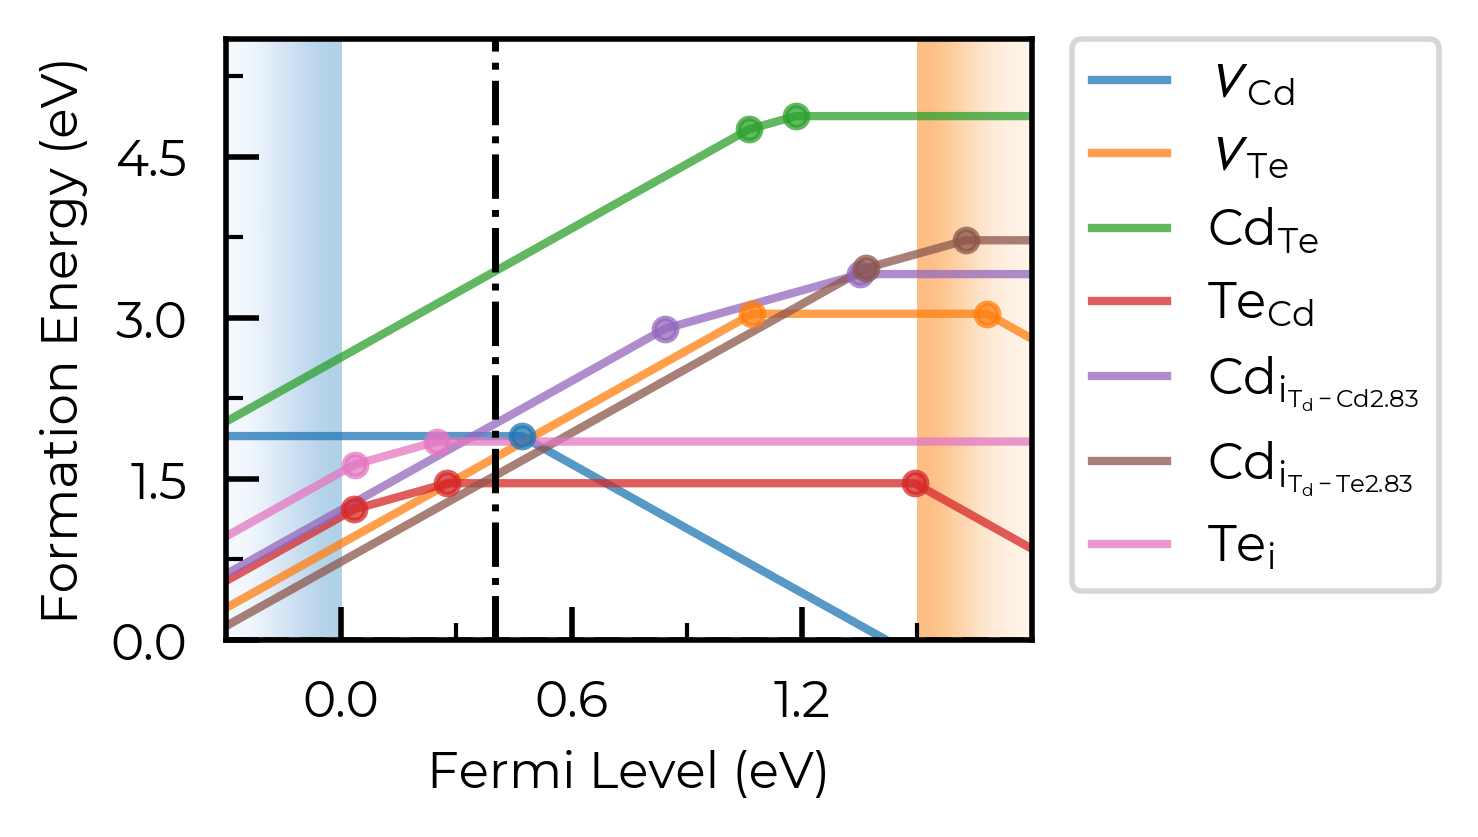

In [30]:
fig = CdTe_thermo.plot(limit="Te-rich", fermi_level=0.4)
fig

### `filename`

We can set `filename` to save the plot to file:

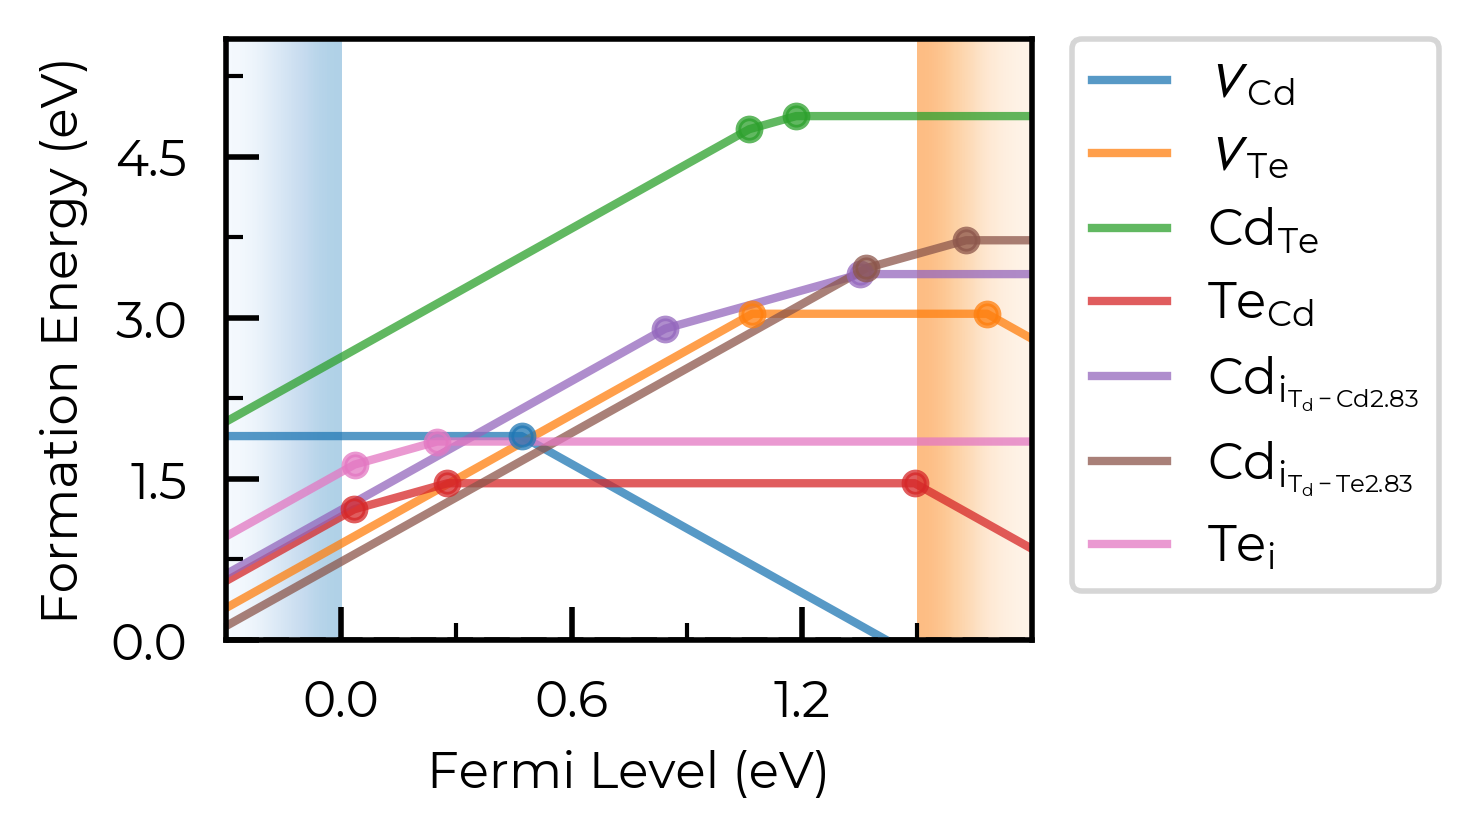

In [31]:
fig = CdTe_thermo.plot(limit="Te-rich", filename="CdTe_defects_plot.png")
fig

## Finite-Size Charge Correction Plots

Both the Freysoldt (FNV) and Kumagai (eFNV) charge correction plots in `doped` are also quite customisable, and as always return the `Matplotlib` `Figure` object to allow further customisation.

### eFNV (Kumagai) Correction

As shown in the `doped` docs [Tips page](https://doped.readthedocs.io/en/latest/Tips.html#layered-low-dimensional-materials), we can set `defect_region_radius` and/or `excluded_indices` with the eFNV correction (`get_kumagai_correction()`) to control which sites away from the defect site are used to determine the potential alignment – which we may want to do with e.g. low-dimensional materials.

In [34]:
te_cd_entry = CdTe_thermo.defect_entries["Te_Cd_+1"]

Calculated Kumagai (eFNV) correction is 0.238 eV


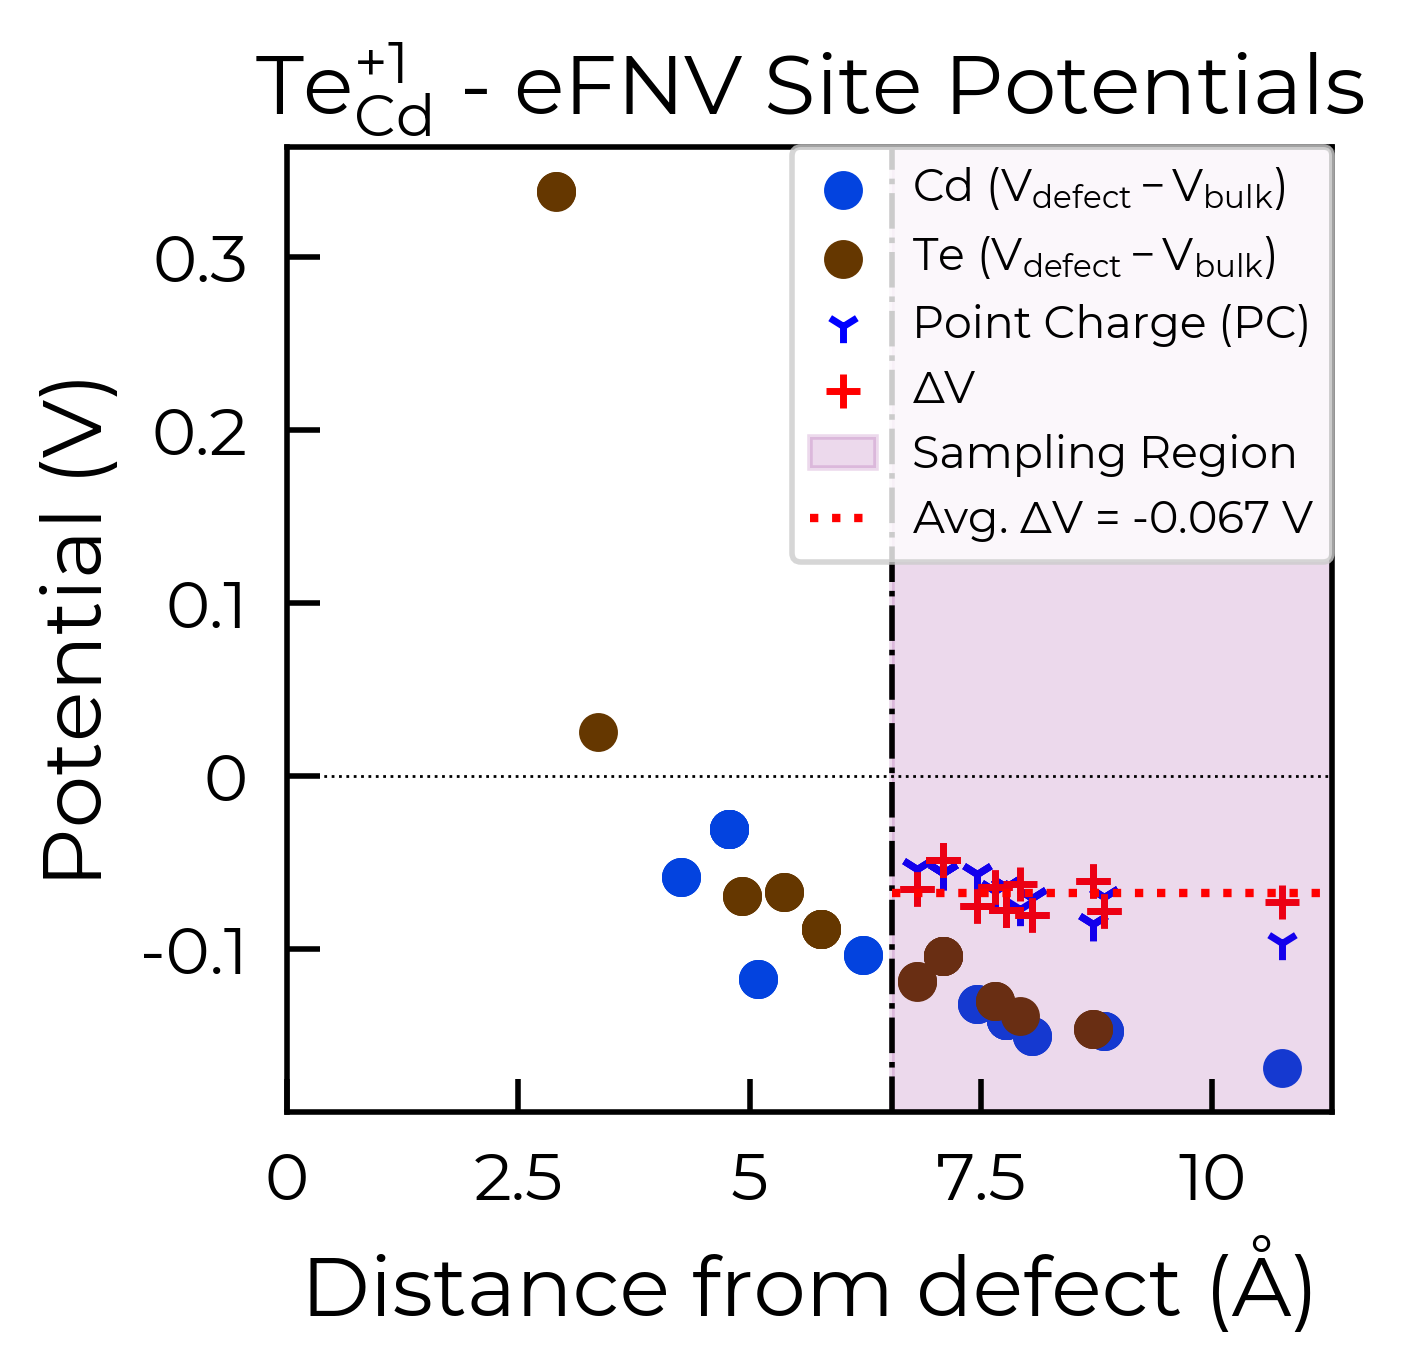

In [35]:
correction, fig = te_cd_entry.get_kumagai_correction(plot=True)
fig

As with the defect formation energy plots, because this function also returns the `Matplotlib` `Figure` object, we can further customise the plot as we see fit. To illustrate, here we remove the legend from the plot and shade the region where the potential is positive in yellow:

Calculated Kumagai (eFNV) correction is 0.238 eV


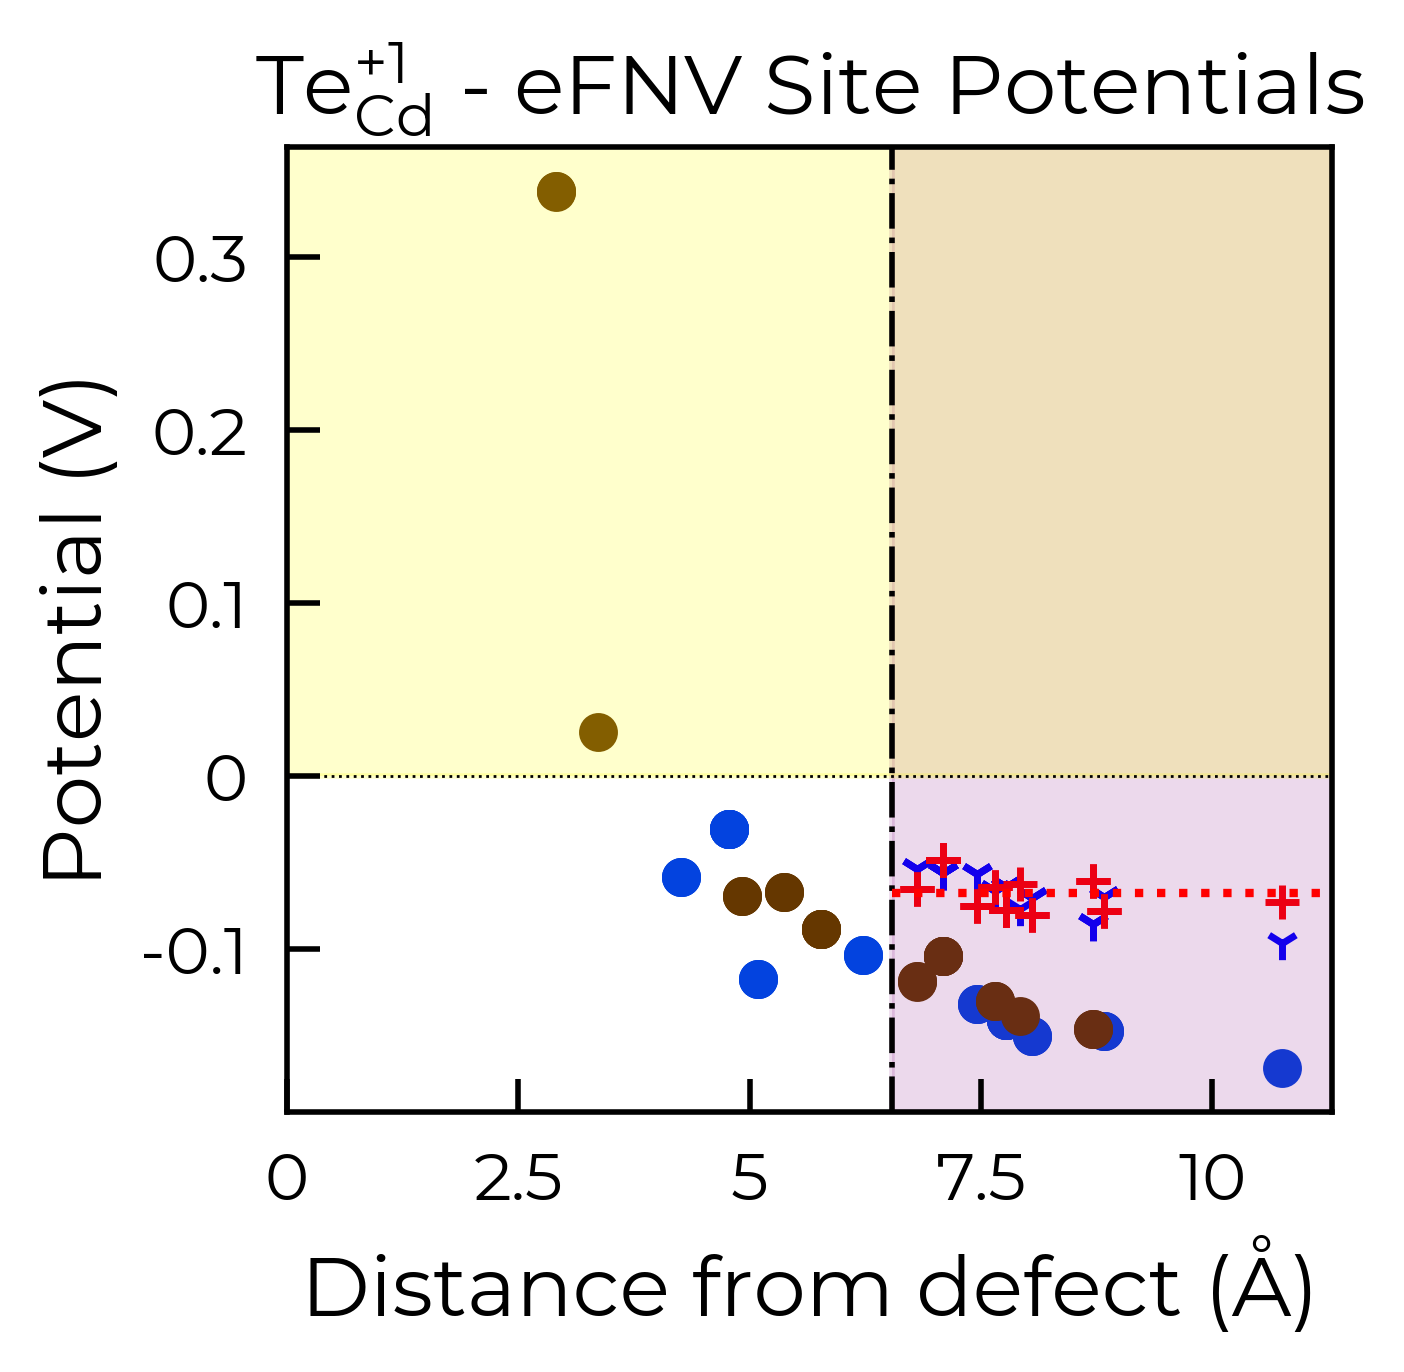

In [36]:
correction, fig = te_cd_entry.get_kumagai_correction(plot=True)
ax = fig.gca()  # get axis object
ax.get_legend().remove()  # remove legend
ax.axhspan(0, 100, alpha=0.2, color="yellow")
fig

### `style_file`

As with the defect formation energy plots, we can adjust the overall style of the plot by using a custom `matplotlib` style (`mplstyle`) file:

In [37]:
with open("custom_style.mplstyle", "w") as f:
    f.write("ytick.right : True\nxtick.top : True\nfont.sans-serif : Helvetica")

Calculated Kumagai (eFNV) correction is 0.238 eV


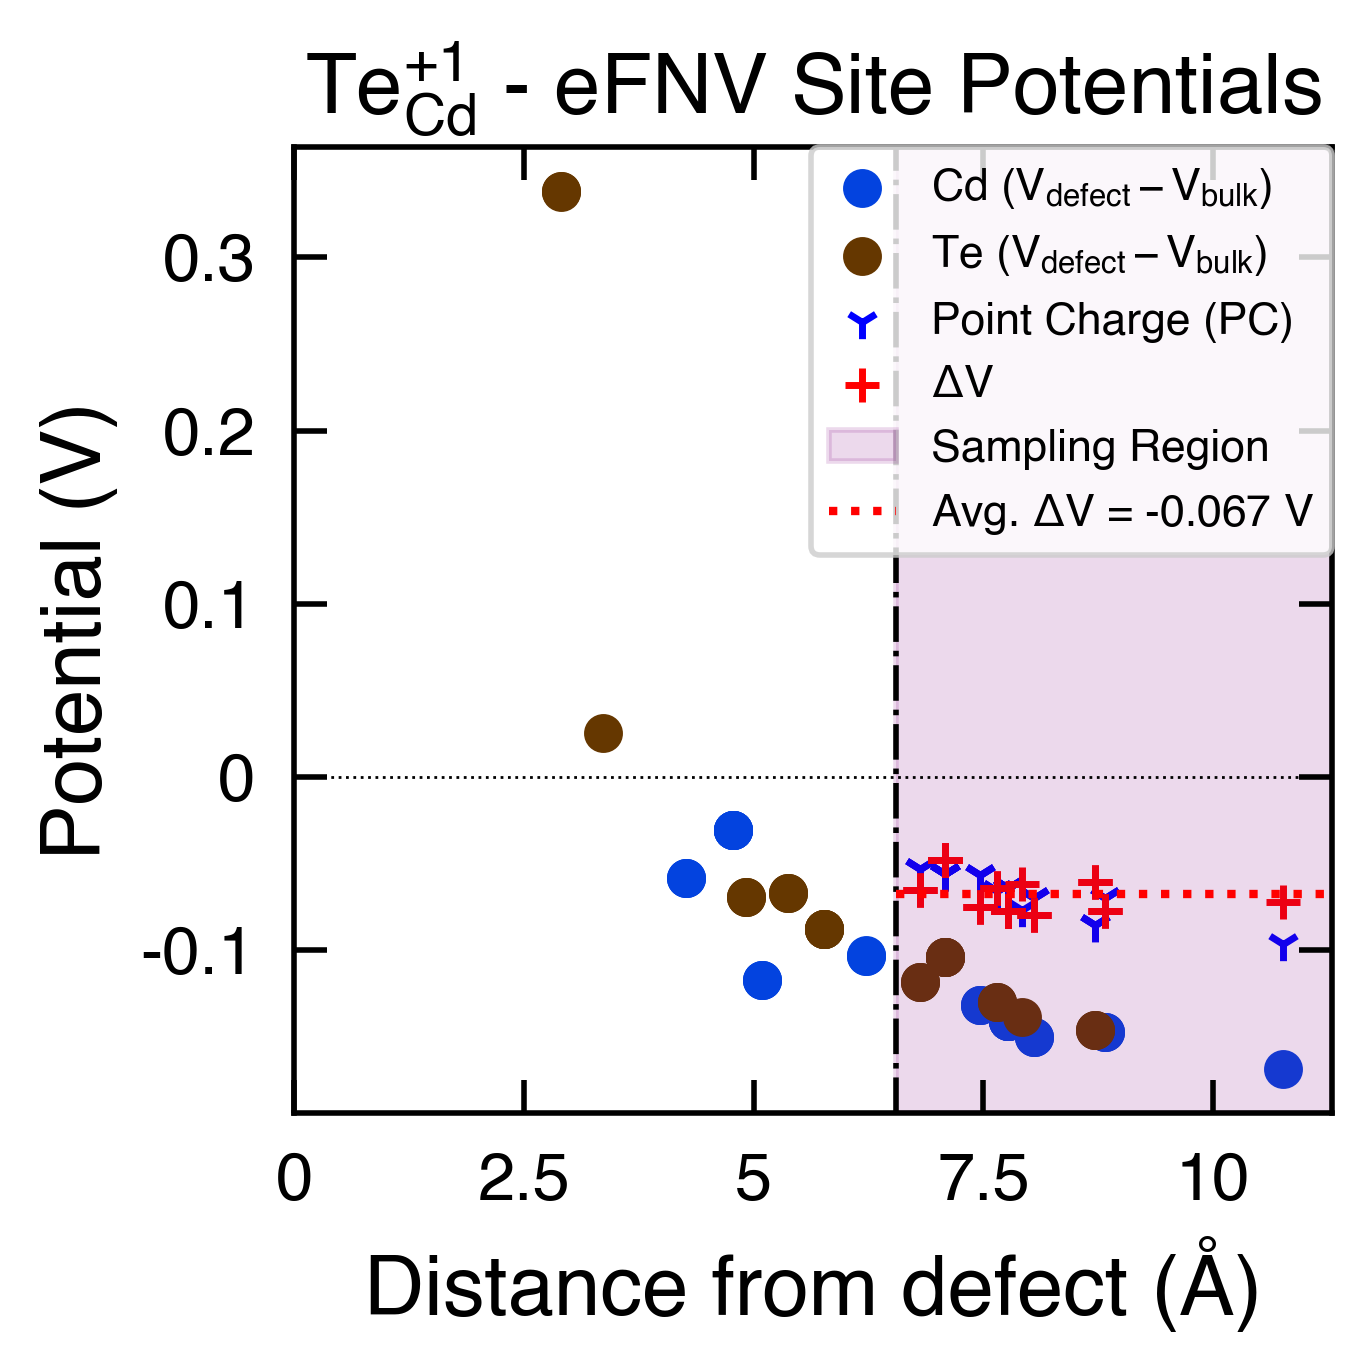

In [38]:
correction, fig = te_cd_entry.get_kumagai_correction(plot=True, style_file="custom_style.mplstyle")  
fig

### FNV (Freysoldt) Correction
Remember, the Freysoldt (FNV) correction is only valid for isotropic systems!

In [40]:
v_cd_entry = CdTe_thermo.defect_entries["v_Cd_-2"]

Calculated Freysoldt (FNV) correction is 0.738 eV


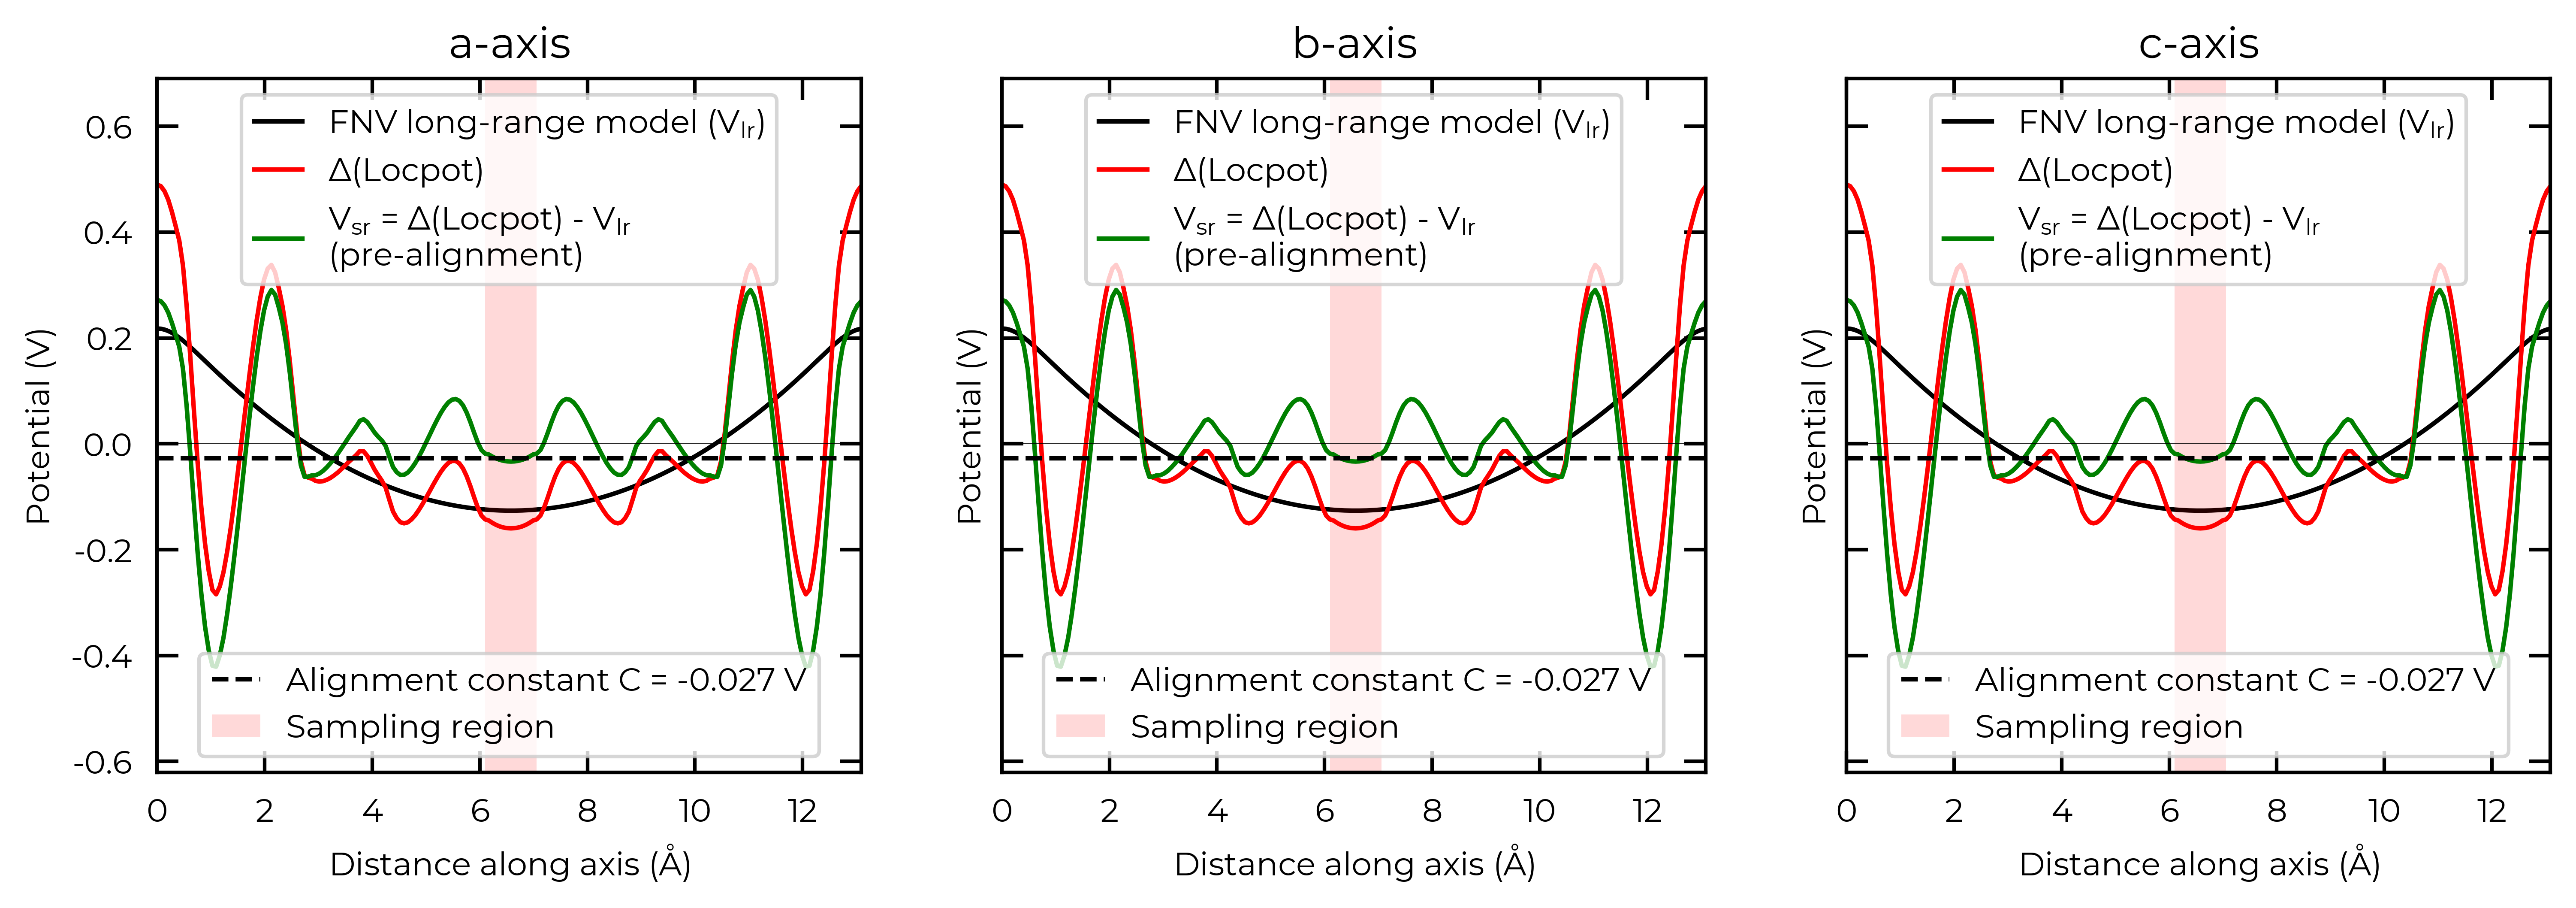

In [41]:
correction, fig = v_cd_entry.get_freysoldt_correction(plot=True)
fig

For the FNV correction, it calculates the electrostatic potential alignment along the _a_, _b_ and _c_ axes and then computes the average. We can focus on just one axis at a time by setting `axis`:

Calculated Freysoldt (FNV) correction is 0.738 eV


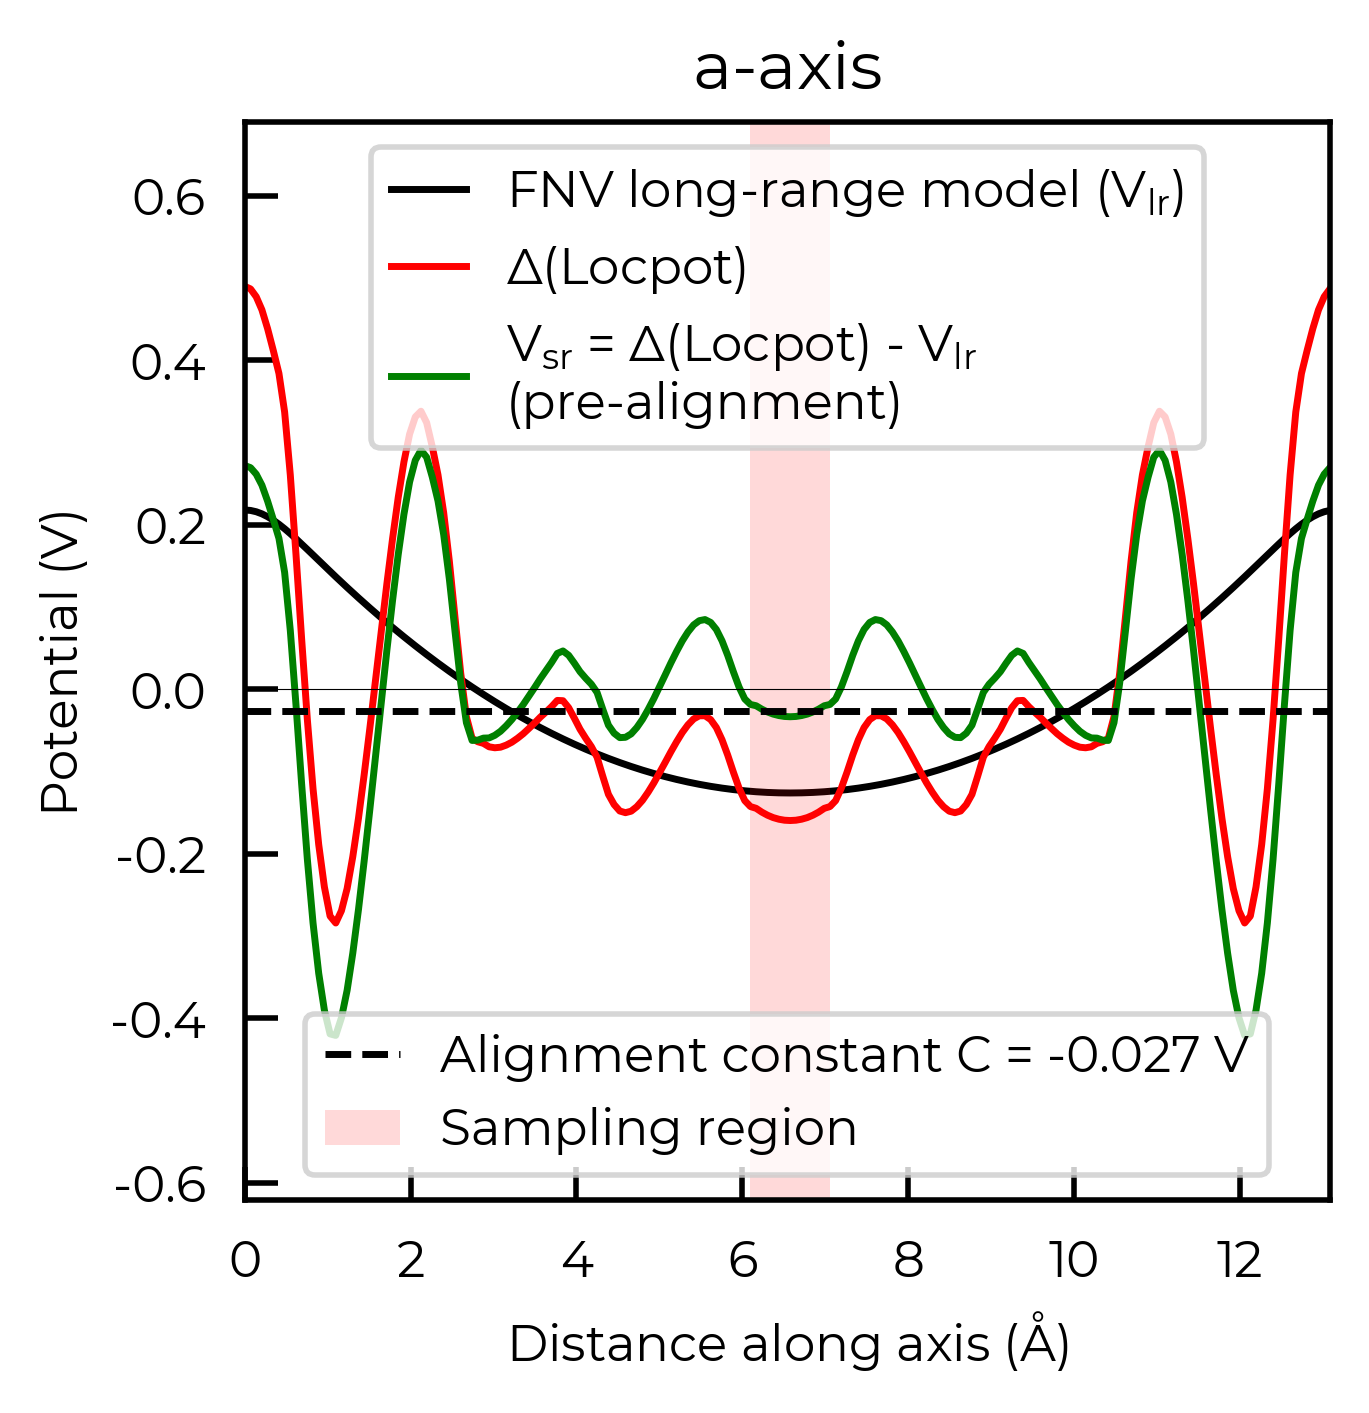

In [42]:
correction_a, fig_a = v_cd_entry.get_freysoldt_correction(plot=True, axis=0)
fig_a

Again, because this function also returns the `Matplotlib` `Figure` object, we can further customise the plot as we see fit. To illustrate, here we remove the legends from each plot and shade the region where the potential is positive in yellow:

Calculated Freysoldt (FNV) correction is 0.738 eV


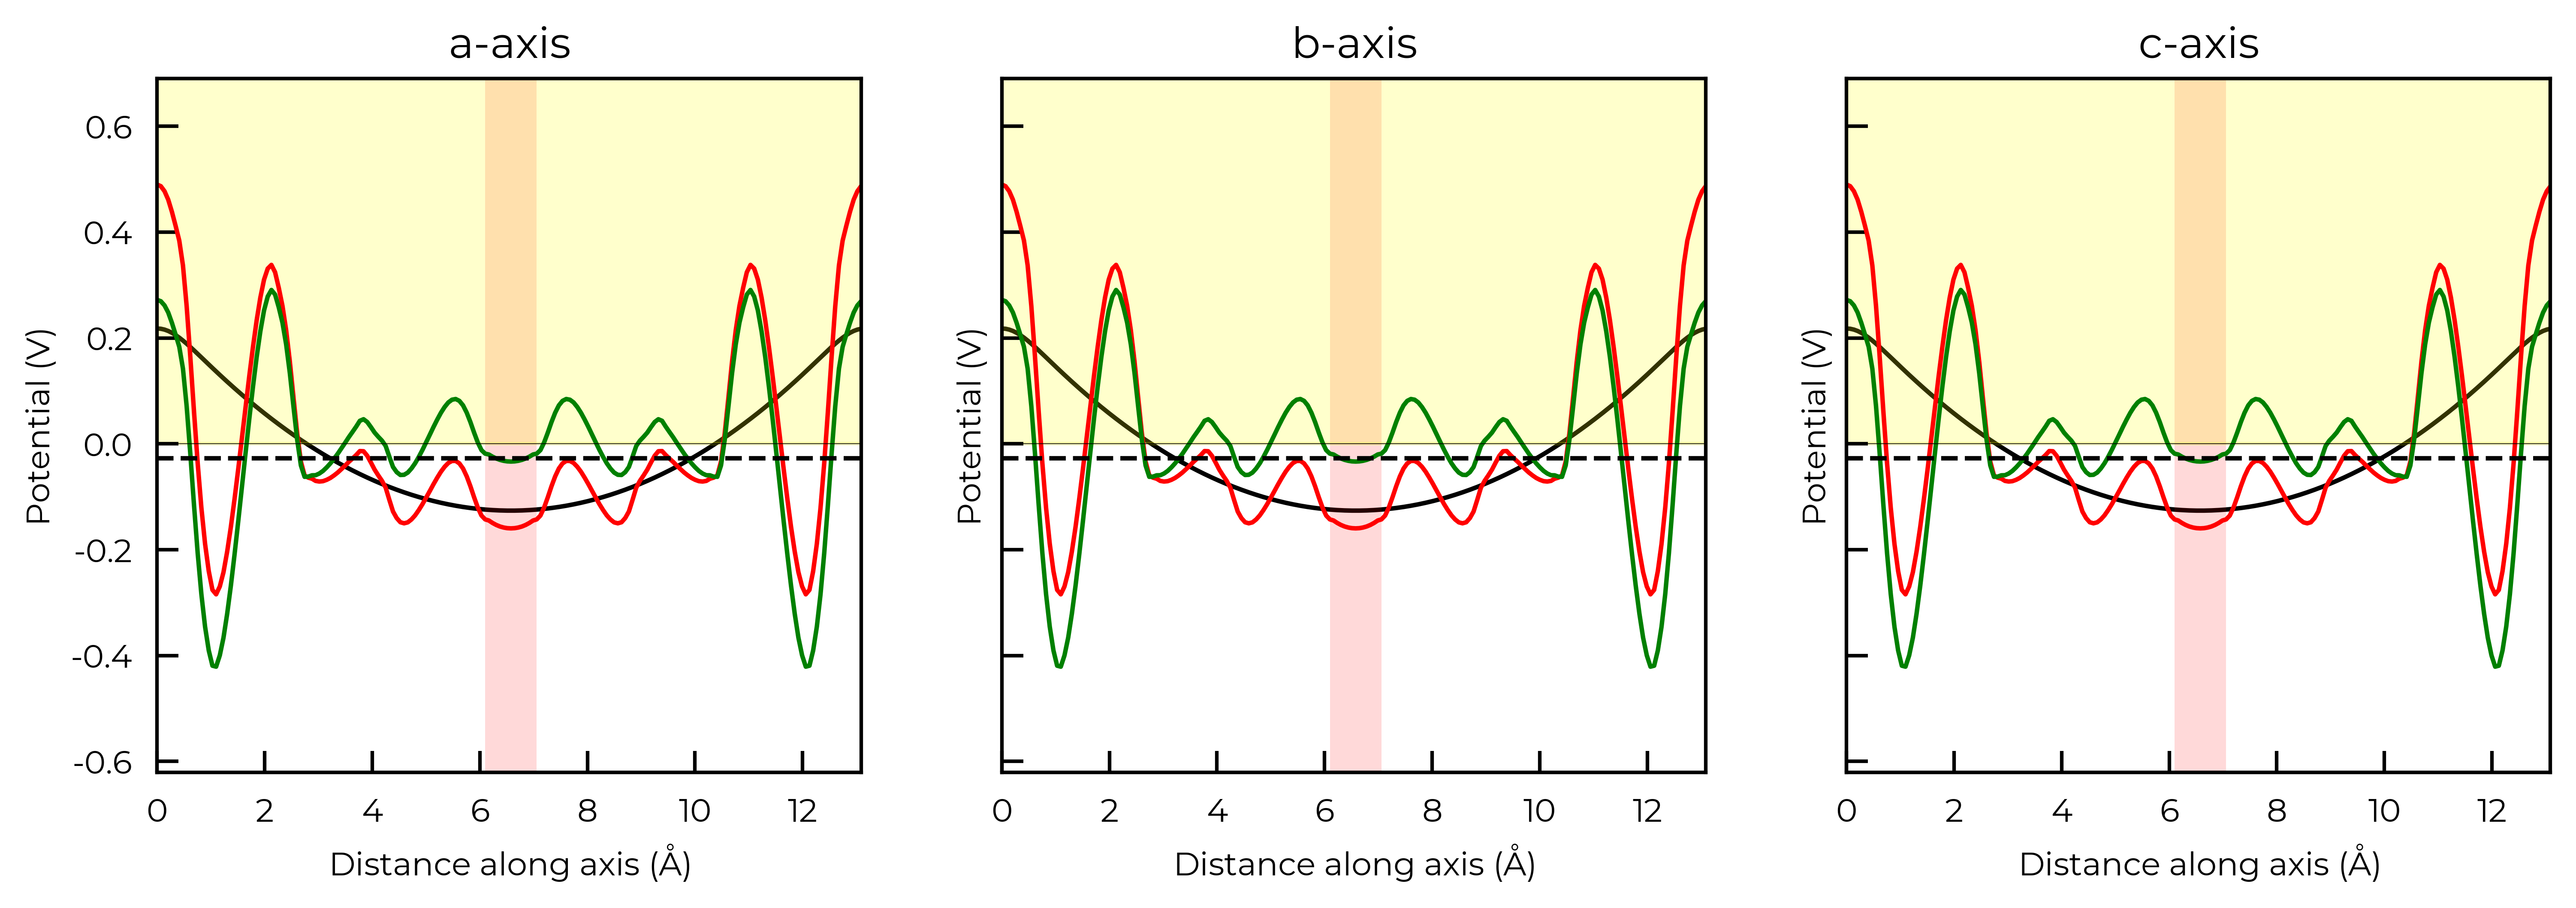

In [43]:
correction, fig = v_cd_entry.get_freysoldt_correction(plot=True)
for ax in fig.get_axes():
    ax.get_legend().remove()  # remove legend
    ax.artists[0].remove()  # shade the region where the potential is positive
    ax.axhspan(0, 100, alpha=0.2, color="yellow")
fig

### `style_file`

As with the defect formation energy plots, we can adjust the overall style of the plot by using a custom `matplotlib` style (`mplstyle`) file:

In [44]:
with open("custom_style.mplstyle", "w") as f:
    f.write("ytick.right : True\nxtick.top : True\nfont.sans-serif : Helvetica")

Calculated Freysoldt (FNV) correction is 0.738 eV


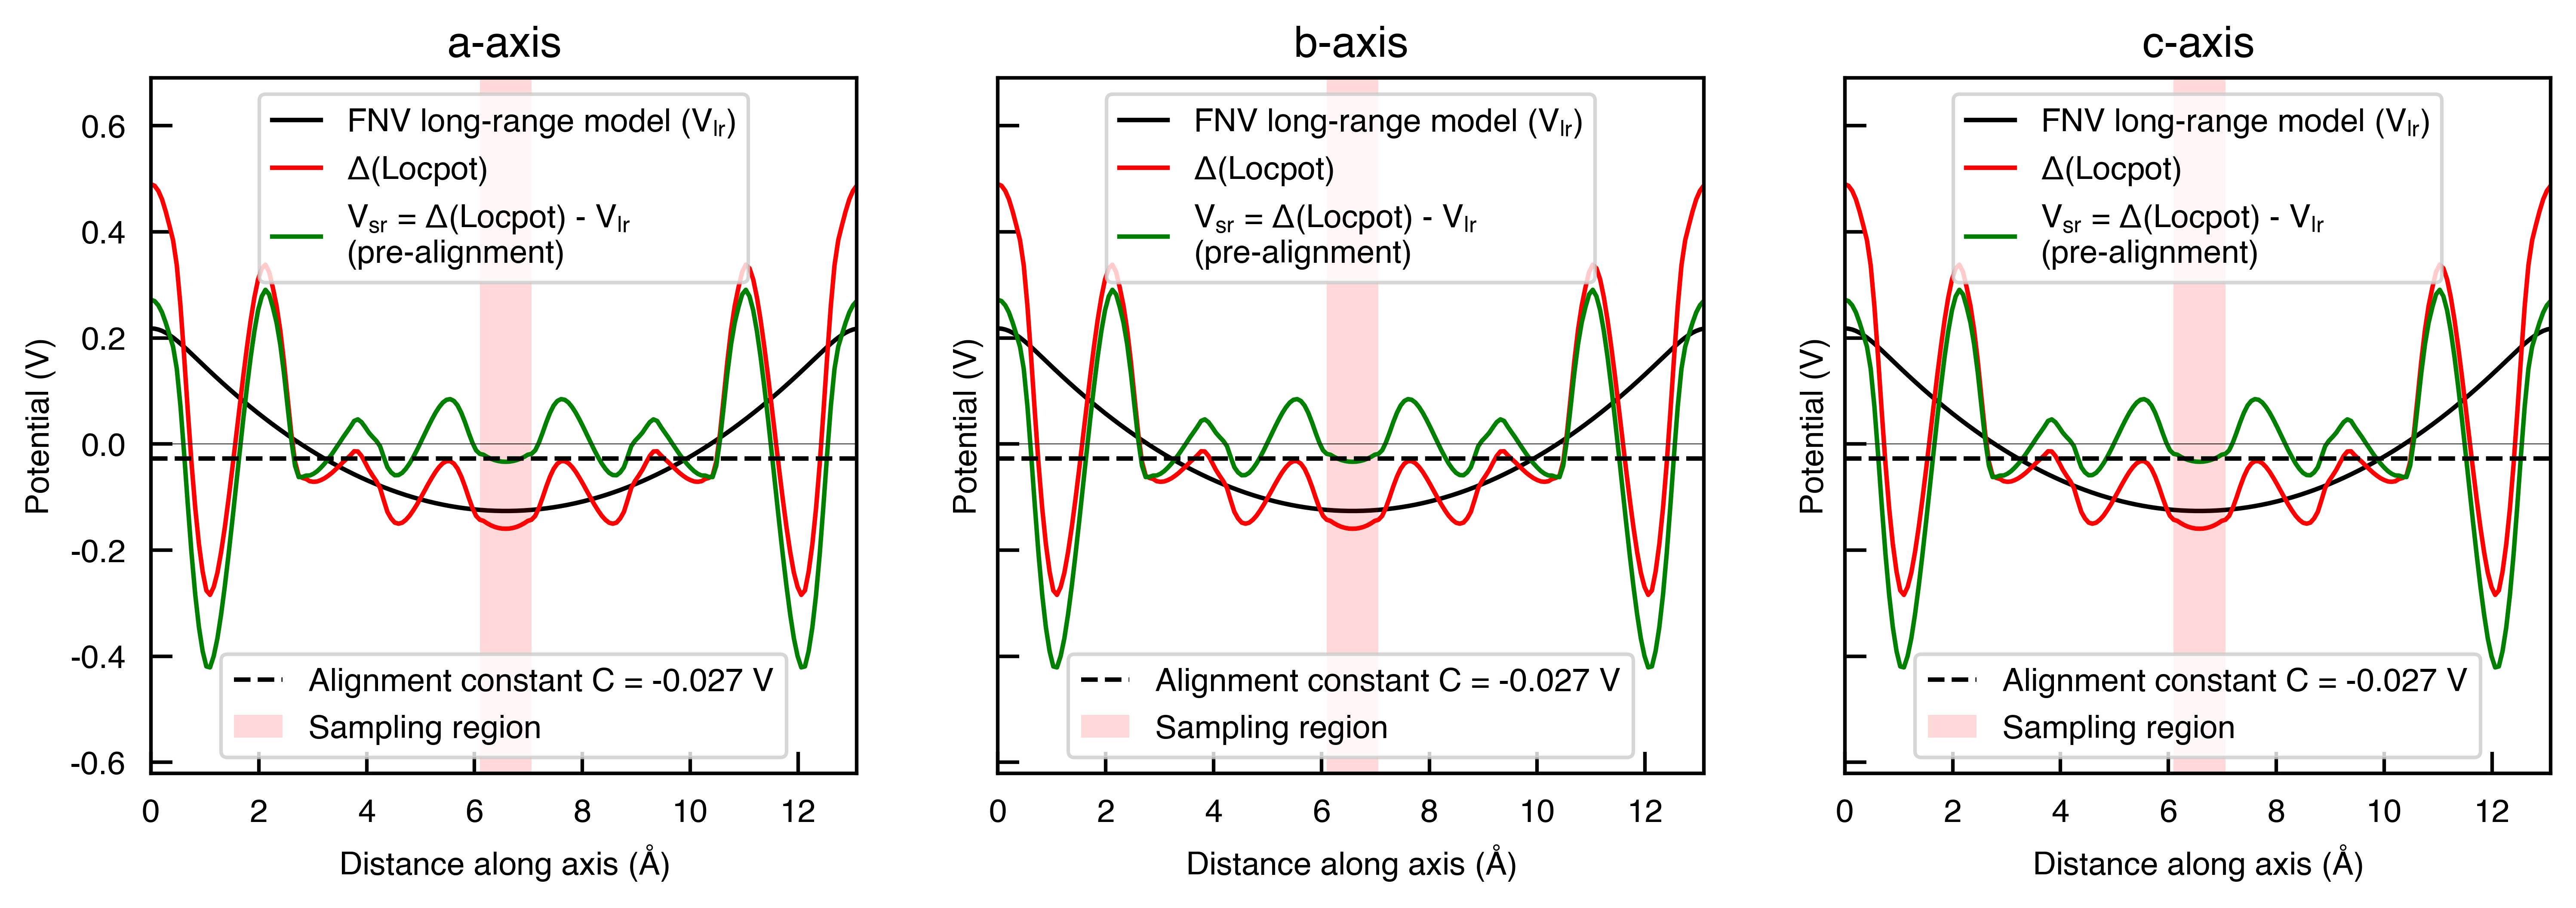

In [45]:
correction, fig = v_cd_entry.get_freysoldt_correction(plot=True, style_file="custom_style.mplstyle")
fig

## Site Displacement / Strain Plots

As shown in more detail in the advanced analysis tutorial, the `DefectEntry.plot_site_displacements()` method and functions in `doped.utils.displacements` can be quite useful for analysing the lattice response (site displacements) and local strain for a relaxed defect structure. 

Again, these functions return the `Matplotlib` `Figure` object to allow further customisation (more examples shown in the advanced analysis tutorial):

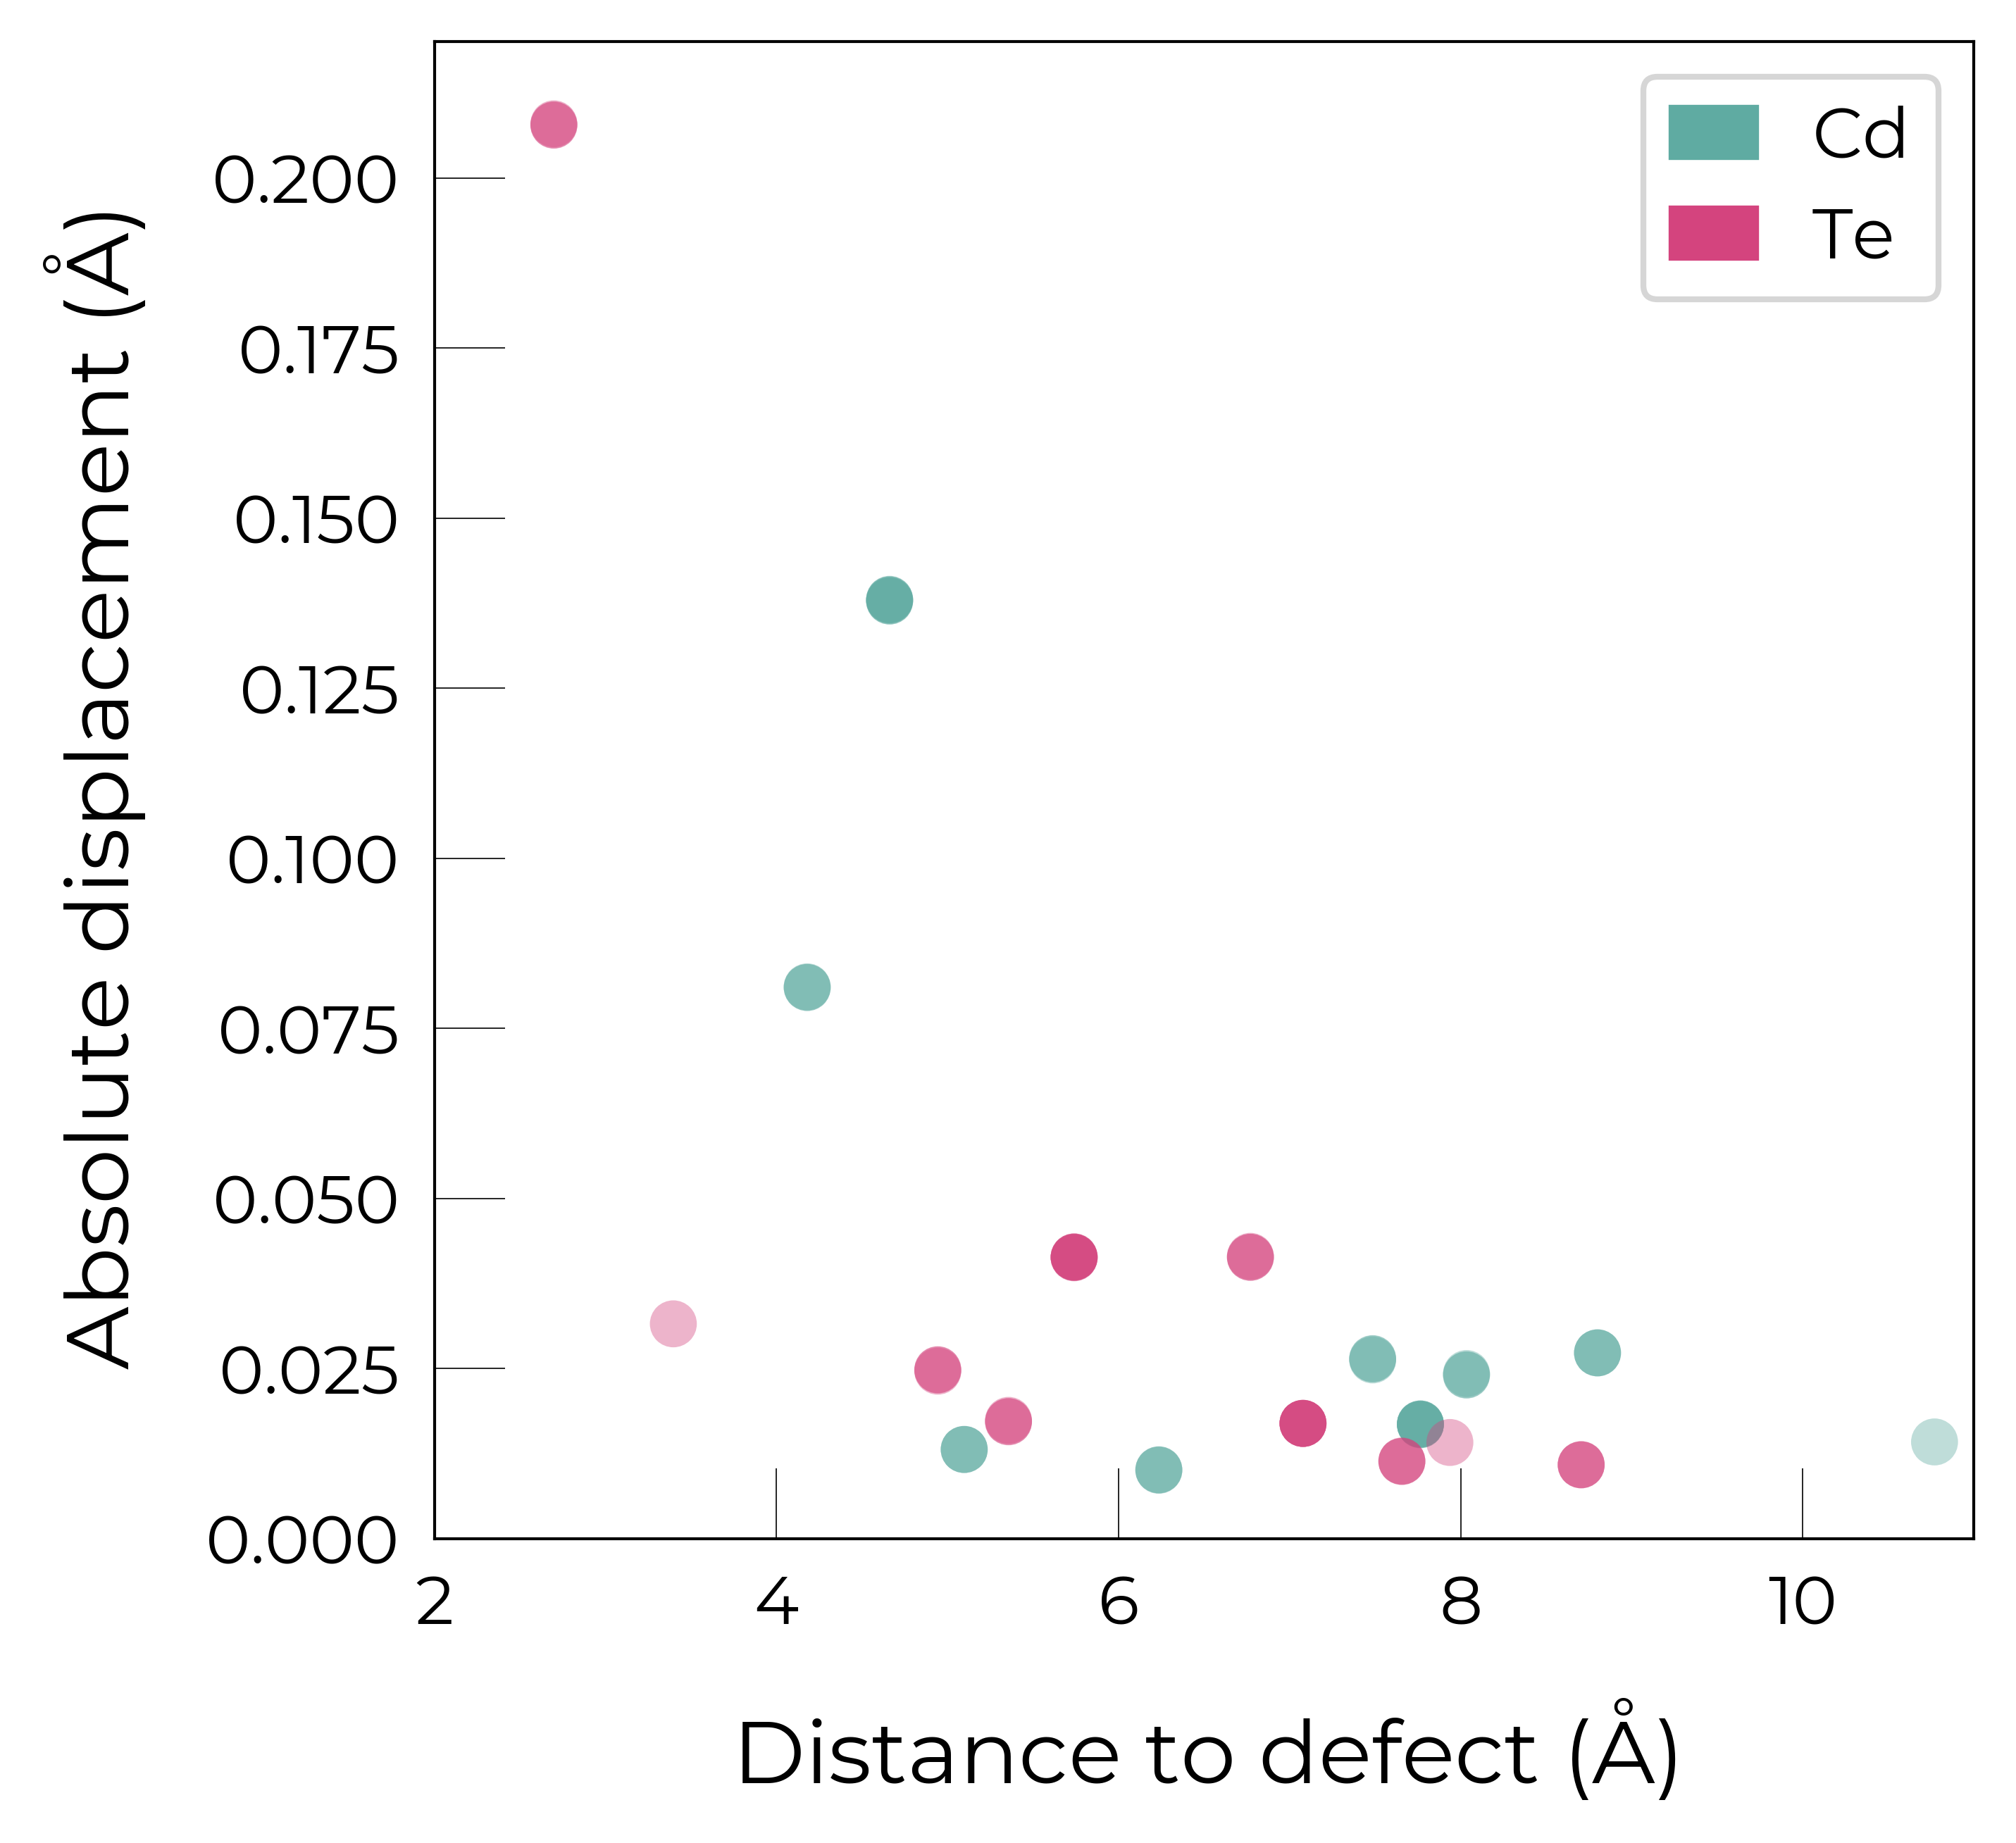

In [46]:
te_cd_entry = CdTe_thermo.defect_entries["Te_Cd_+1"]
fig = te_cd_entry.plot_site_displacements()
ax = fig.gca(); ax.set_xlim(2, 11); ax.set_ylim(0, 0.22);  # adjust x/y-lims
fig

## Eigenvalue Plots

As shown in more detail in the advanced analysis tutorial, the `DefectEntry.get_eigenvalue_analysis()` method and functions in `doped.utils.eigenvalues` can be quite useful for analysing the electronic structure of our defect calculations.

Again, these functions return the `Matplotlib` `Figure` object to allow further customisation:

   INFO: The eigenvalues are shifted by -1.65


INFO:pydefect.analyzer.band_edge_states:The eigenvalues are shifted by -1.65


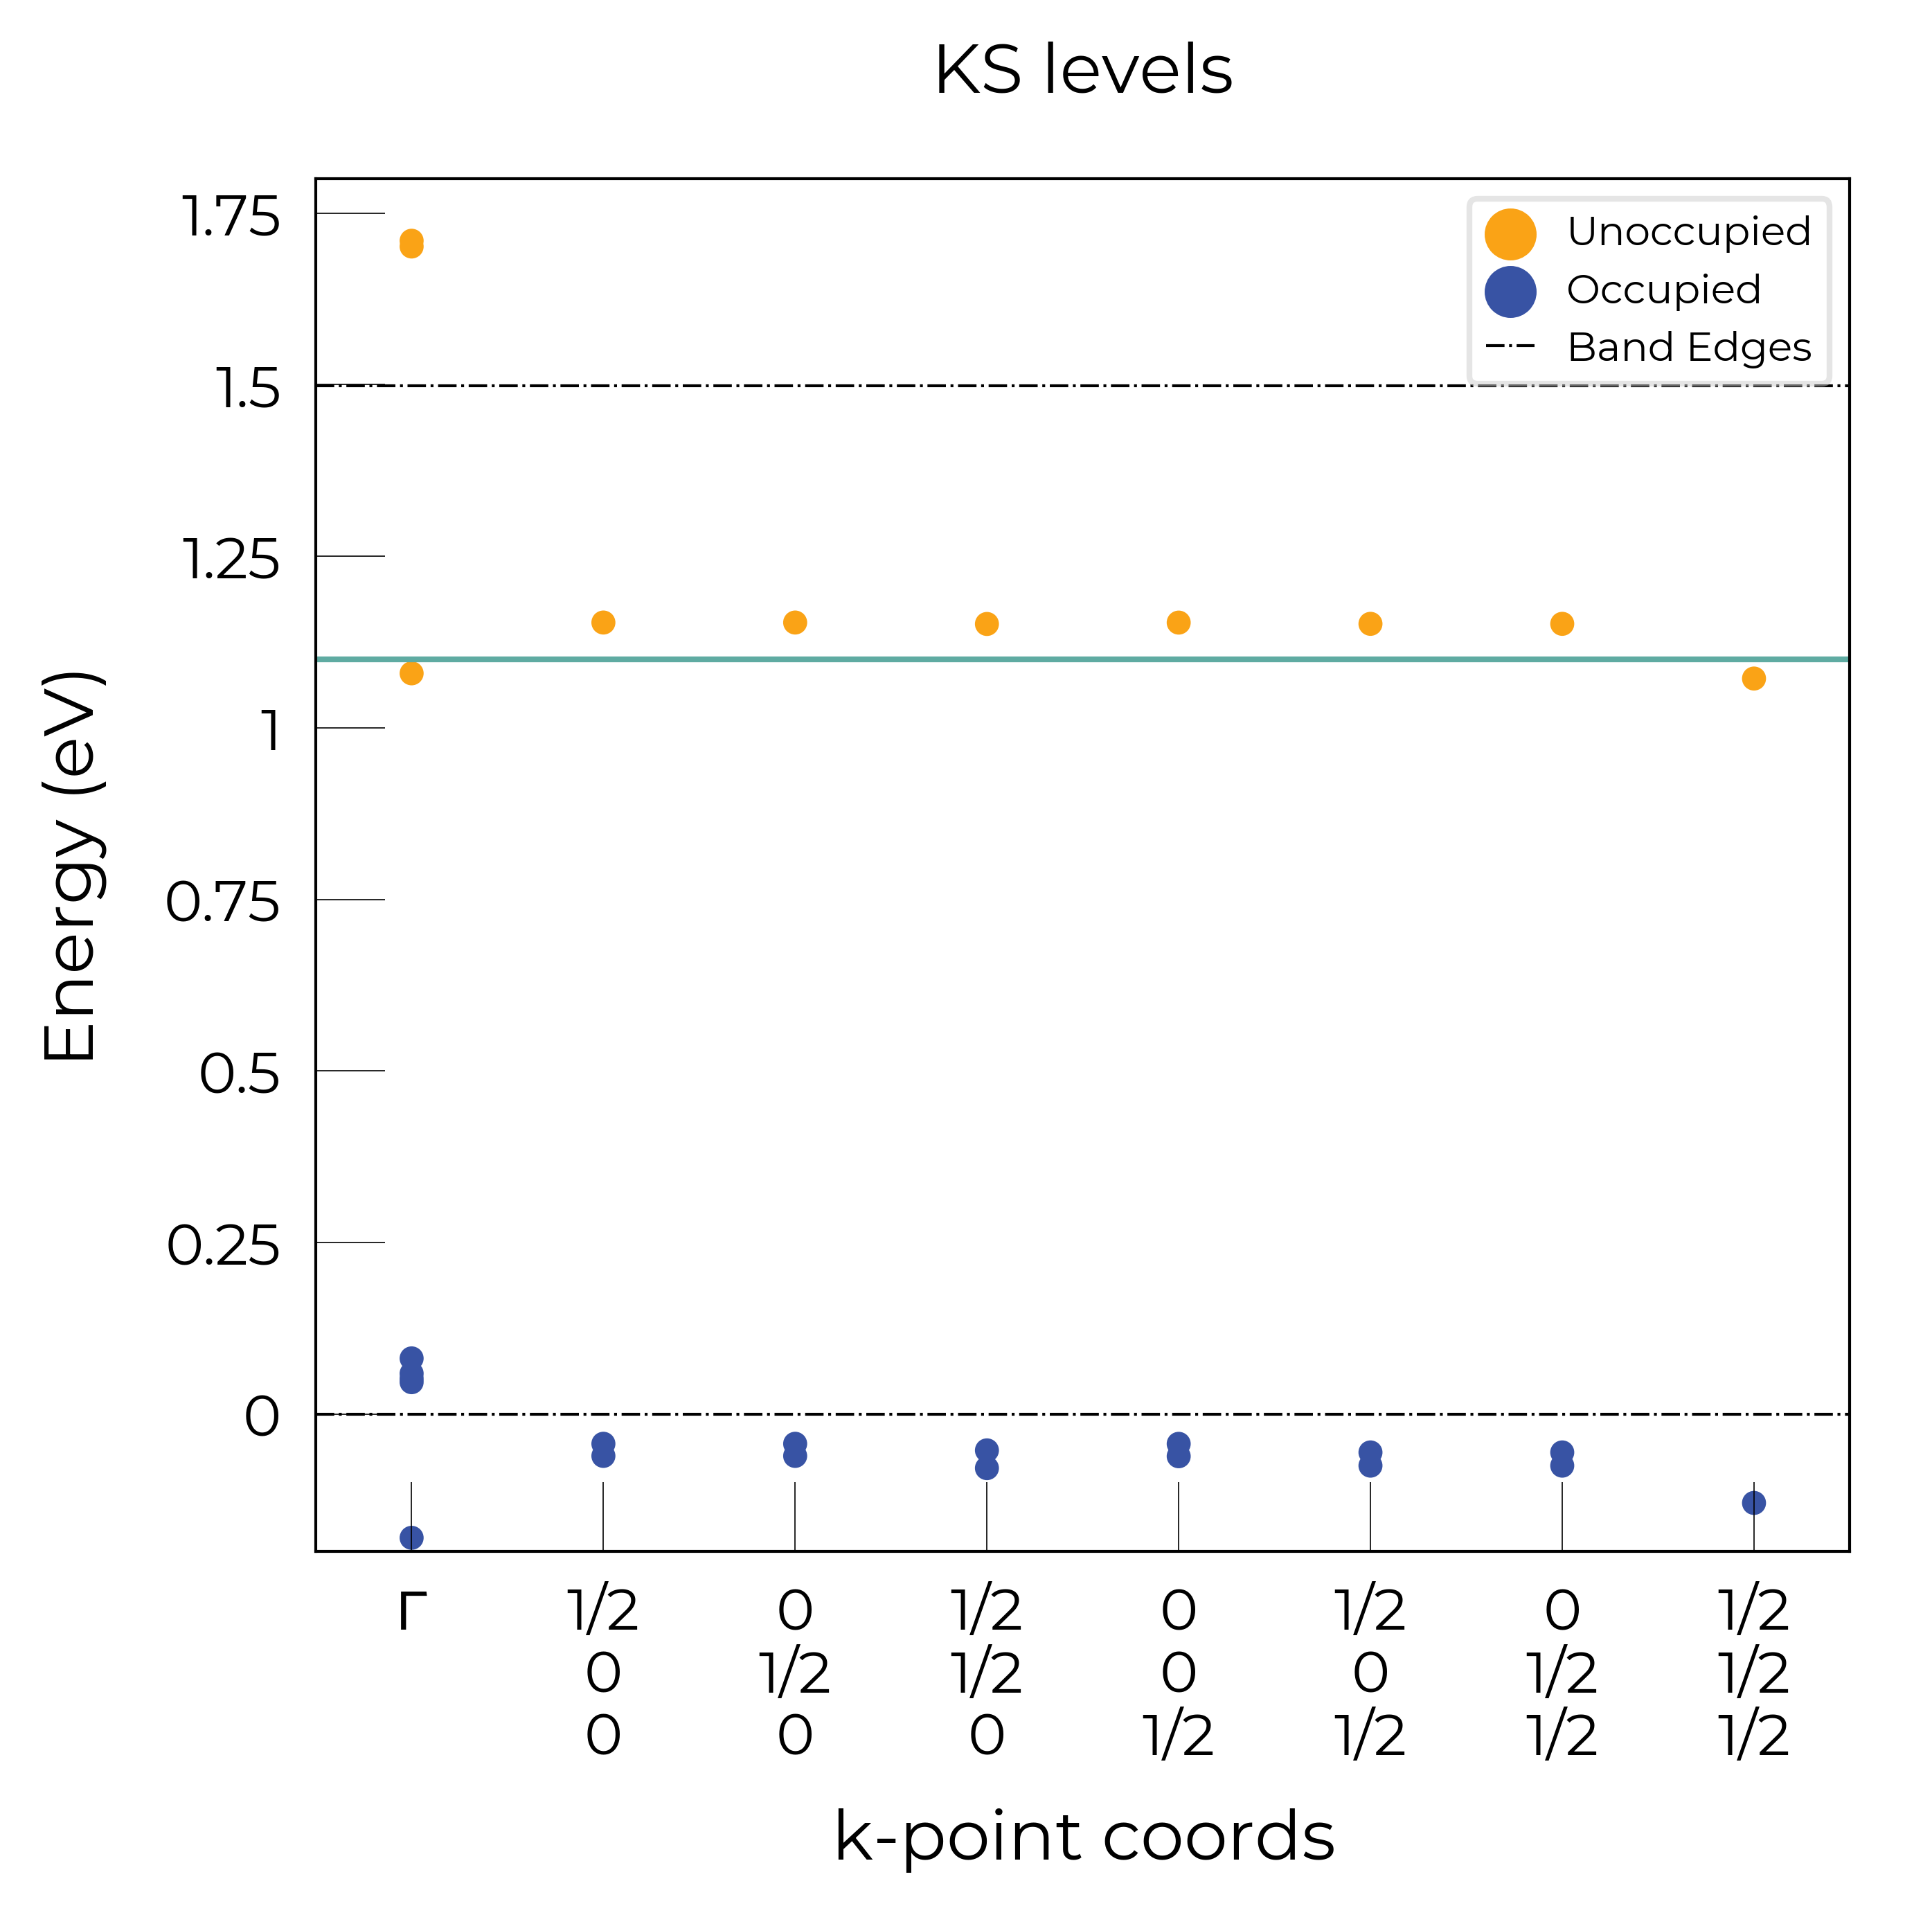

In [47]:
te_cd_entry = CdTe_thermo.defect_entries["Te_Cd_+1"]
bes, fig = te_cd_entry.get_eigenvalue_analysis()
# adjust ylim and add line around defect level:
ax = fig.axes[0]; ax.set_ylim(-0.2, 1.8), ax.axhline(1.1)  
fig